In [1]:
import sys
import seaborn as sns
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import plot as pltfn
import admin_functions as adfn
from scipy import stats 

sns.reset_orig()
#plt.style.use('dark_background')

%load_ext autoreload
%autoreload
     
# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

## PLOT1
### How do parameter combinations effect power law distributions 

* alter: firing probability and avalanche neighbour binning
* try altering neighbour binning and noise (varC/varB)
* measure: exponent and log likelihood 

In [2]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
powlist = sorted(glob.glob('*power.npy*')) 
loglist = sorted(glob.glob('*logn*'))

### Fit power law - calculate exponents

In [ ]:
shape = 320
avlist = list(range(shape))
nums = adfn.name(F10t, experiment, 2, 12)
for t in nums:
    itav = sorted(glob.glob('*E-' + str(t) + '*nnbav.npy*')) 
    for i in range(len(itav)): 
        avlist[i] = powerfit(Fdrop, experiment, np.load(itav[i])[0])
    np.save(Fdrop + 'Project/' + experiment + os.sep + itav[i][:itav[i].find('run')+6] + 'sizeparamsweepp_log', avlist)
    print('Done fish num ' + str(f))     

In [ ]:
for i in num1:
    avlist =  sorted(glob.glob('*-' + i + '*BLN*nnbav.npy'))[:180]
    powerlist = list(range(200))
    lognlist = list(range(200))
    for e in range(len(avlist)):
        data = np.load(avlist[e])
        sizes=data[0,:]
        M=len(sizes)
        a=min(sizes) #define xmin
        b=max(sizes) #define xmax
        npart = 2000 #number of particles - number of draws from prior distribution
        ln=IS_LN(npart)
        po=IS(npart)
        powerlist[e] = po
        lognlist[e] = ln
        print('Done param ' + str(e) + 'for fish ' + adfn.name_template([avlist[e]], 'short'))
    np.save(Fdrop + 'Project/' + experiment + os.sep + adfn.name_template([avlist[e]], 'short') + '_marglik_power.npy', powerlist)
    np.save(Fdrop + 'Project/' + experiment + os.sep + adfn.name_template([avlist[e]], 'short') + '_marglik_logn.npy', lognlist)
    print('Done fish ' + adfn.name_template([avlist[e]], 'short'))

In [53]:
import numpy as np 
import scipy.stats as stat
import matplotlib.pyplot as plt

#Functional form for power law
def powerlaw(n,lam):
    zeta=np.sum(1.0/np.arange(a,b+1)**lam)
    return(n**(-lam)/zeta)

#Functional form for lognormal
def lognormal(n,mu,sig):
    return(1.0/n/np.sqrt(2*np.pi*sig**2)*np.exp(-(np.log(n)-mu)**2/(2*sig**2)))


#Calculate loglikelihood for power law given the data
#Likelihoods across all random draws, given your data
def LogLikelihood(lam):
    #normalisation factor for all lambda draws - normalises a distribution to sum of probability = 1 (by summing across all possible values in density)
    zetamat=np.power.outer(1.0/np.arange(a,b+1),lam) #Matrix of normalisation constants for each lambda draw, at each size: each row =  size**-current lambda, for every size from max to min
    zeta=np.sum(zetamat,0) #Norm vector - for each lambda draw - sum of norm constants for entire size max-min range at each lambda
    norm=-M*np.log(zeta) #Contribution of zeta to the likelihood
    nprod=-lam*np.sum(np.log(sizes)) #Loglikelihood calculation, given the data
    loglik=nprod+norm #Normalised loglikelihood
    return(loglik) 

#Calculate loglikelihood for lognormal
#Likelihoods across all random draws, given your data
def LogLikelihood_LN(mu,sig):
    T1 = -np.sum(np.log(sizes))
    T2_mat = np.subtract.outer(np.log(sizes),mu)**2
    T2 = -np.sum(T2_mat,0)/(2*sig**2)
    T0 = -M*np.log(np.sqrt(2*np.pi) * sig )
    loglik=T0+T1+T2
    return(loglik) 


#IMPORTANCE SAMPLER - for power law - monte carlo sampling from two different distributions
#OUTPUT - posterior average exponent, log marginal likelihood, effective sample size = how good is the sampler
def IS(npart):
    lambda_sample=np.random.uniform(0.1,5,npart) #randomly sample 

    #Weights - loglikelihoods of your data for each lambda * (weight by) log probability of drawing each lambda sample from the prior, divided by log probability of drawing each lambda sample from the proposal
    #Likelihood of data weighted by prior expectation of lambda, and proposal expected lambda - cancel out the effect of the proposal
    weights=LogLikelihood(lambda_sample)+stat.norm.logpdf(lambda_sample,1,3)-stat.uniform.logpdf(lambda_sample,0.1,5)
    maxw=np.max(weights)
    w2 = np.exp(weights-maxw)
    w2_sum = np.sum(w2)
    ESS=1.0/(np.sum((w2/w2_sum)**2))
    mean_lambda = np.dot(lambda_sample,w2)/w2_sum #average of the lambda value for the posterior distribution
    #marginal likelihood = empirical means of all the weights
    marglik = maxw + np.log(np.sum(np.exp(weights-maxw)))-np.log(npart) #Take the exponent of logs to unlog, before summing/then divded by ncounts
    return([mean_lambda, marglik, LogLikelihood(lambda_sample), ESS])

#IMPORTANCE SAMPLER - for lognormal - monte carlo sampling from two different distributions
#OUTPUT - posterior average exponent, log marginal likelihood, effective sample size = how good is the sampler
def IS_LN(npart):
    mu_sample = np.random.uniform(-2.0,2.0,npart) #randomly sample mu
    sig_sample = np.random.uniform(0.1,5.0,npart) #randomly sample sigma
    weights=LogLikelihood_LN(mu_sample,sig_sample)
    maxw=np.max(weights)
    w2 = np.exp(weights-maxw)
    w2_sum = np.sum(w2)
    ESS=1.0/(np.sum((w2/w2_sum)**2))
    wmax_ID=np.argmax(w2)
    mean_mu = mu_sample[wmax_ID]
    mean_sig = sig_sample[wmax_ID]
    #marginal likelihood = empirical means of all the weights
    marglik = maxw + np.log(np.sum(np.exp(weights-maxw)))-np.log(npart)
    return([mean_mu,mean_sig, marglik,  LogLikelihood_LN(mu_sample, sig_sample), ESS])

#find entire posterior dsitr - posterior distribution - range of values 
def plot_samples(npart):
    lambda_sample=np.random.uniform(0.1,5,npart)
    weights=LogLikelihood(lambda_sample)
    maxw=np.max(weights)
    w2 = np.exp(weights-maxw)
    plt.hist(lambda_sample,weights=w2,bins=np.linspace(2.5,2.8))
    plt.show()

def plotcomp(lam,mu,sig):
    x = np.linspace(a,b,40) 
    plt.hist(sizes,40,log=True,density=True)
    plt.plot(x,powerlaw(x,lam))
    plt.plot(x,lognormal(x,mu,sig))
    plt.show()

## Plot parameter sweep

### Exponent
* fit to each fish individually - then take average 
* perform unbiased sweep across "reasonable" parameter values - e.g. minimise variance = 0.23nnb, 0.610 bin
* BCL - threshold - provide actual model values (explain in legend)
* percentile of closest cells

In [3]:
shape = (200)
count=0
expsum = np.zeros((shape))
for i in range(shape):
    evec = []
    for t in range(len(powlist)):
        if type(np.load(powlist[t], allow_pickle=True)[i]) is not int:
            evec = np.append(evec, np.load(powlist[t], allow_pickle = True)[i][0])
        expsum[i] = np.sum(evec)/len(evec) 

In [145]:
xlist = list(range(21))
for i in range(len(xlist)):
    xlist[i] = str(np.int(np.linspace(3,23, 21)[i]))

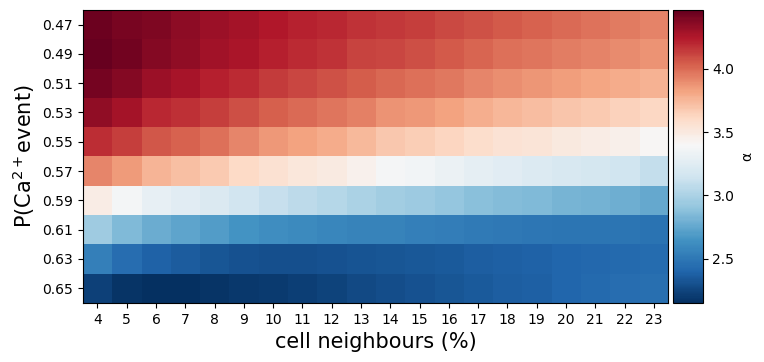

In [237]:
#EXPONENT
from mpl_toolkits.axes_grid1 import make_axes_locatable
divnorm = colors.DivergingNorm(vmin=np.min(expsum), vcenter=3.4, vmax=np.max(expsum))
f, ax = plt.subplots(figsize = (8,5))
nnbs = 20
bcls = np.int(expsum.shape[0]/nnbs)
expav = expsum.reshape((bcls,nnbs))    
plot1 = ax.imshow(expav, cmap = 'RdBu_r', norm = divnorm)
ax.set_xlabel('cell neighbours (%)', size = '15')
ax.set_ylabel('P(Ca$^{2+}$event)', size = '15')
ax.locator_params(axis='y', nbins=10)
ax.locator_params(axis='x', nbins=20)
ax.set_xticklabels(xlist, fontsize = 10)
ax.set_yticklabels(adfn.name_zero('back', 0.45, 0.65, 0.02), fontsize = 10)
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
cbar0 = f.colorbar(plot1, cax=cax0, label = 'α')
plt.show()

#### Marginal likelihood map
* calculate individual marginal likelihood values for each fish - average for map
* loglik ratio - sum marglik power law vs lognormal - ratio: where power law

In [182]:
shape = (200)
mratio = np.zeros((shape))
for i in range(shape):
    powvec, logvec = 0,0
    for t in range(len(powlist)):
        if type(np.load(powlist[t], allow_pickle=True)[i]) is not int:
            powvec = powvec + np.load(powlist[t], allow_pickle = True)[i][1]
            logvec = logvec +  np.load(loglist[t], allow_pickle = True)[i][2]
    mratio[i] = powvec - logvec

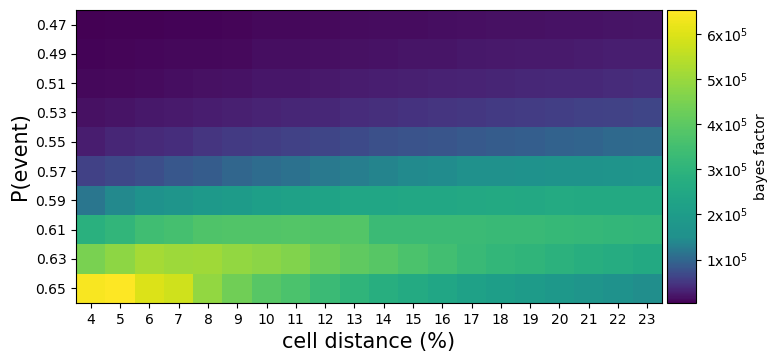

In [230]:
#MARGINAL LIKELIHOOD
from mpl_toolkits.axes_grid1 import make_axes_locatable
divnorm = colors.DivergingNorm(vmin=np.min(mratio), vcenter=150000, vmax=np.max(mratio))
f, ax = plt.subplots(figsize = (8,5))
nnbs = 20
bcls = np.int(mratio.shape[0]/nnbs)
margav = mratio.reshape((bcls,nnbs))    
plot1 = ax.imshow(margav, cmap = 'viridis', norm=divnorm)
ax.set_xlabel('cell distance (%)', size = '15')
ax.set_ylabel('P(event)', size = '15')
ax.locator_params(axis='y', nbins=10)
ax.locator_params(axis='x', nbins=20)
ax.set_xticklabels(xlist, fontsize = 10)
ax.set_yticklabels(adfn.name_zero('back', 0.45, 0.65, 0.02), fontsize = 10)
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
cbar0 = f.colorbar(plot1, cax=cax0, label = 'bayes factor')
cbar0.ax.set_yticklabels(['1x10$^{5}$', '2x10$^{5}$', '3x10$^{5}$', '4x10$^{5}$', '5x10$^{5}$', '6x10$^{5}$'])  # vertically oriented colorbar
plt.show()

#### Branching ratio map

In [34]:
# PLOT - average whole brain fluorescence
#----------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(F10t + 'Project/' + experiment)
branchlist =  sorted(glob.glob('*-08*BLN*_branch.npy'))

In [35]:
num = adfn.name_zero('front', 2, 12,1)
shape = (200)
b_sum = np.zeros((11, shape))
count=0
for e in num:
    branchlist =  sorted(glob.glob('*E-*' + e + '*BLN*_branch.npy'))
    for i in range(len(branchlist)):
        b_sum[count,i] = np.load(branchlist[i])
    count+=1

b_mean = np.zeros(200)

for i in range(b_sum.shape[1]):
    b_mean[i] = np.sum(b_sum[:,i])/ np.where(b_sum[:,i] >0)[0].shape[0]

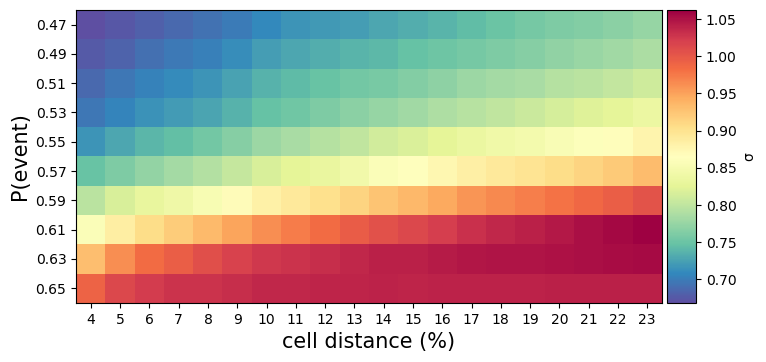

In [36]:
#BRANCHING RATIO
xlist = list(range(21))
for i in range(len(xlist)):
    xlist[i] = str(np.int(np.linspace(3,23, 21)[i]))
from mpl_toolkits.axes_grid1 import make_axes_locatable
#divnorm = colors.DivergingNorm(vmin=np.min(mratio), vcenter=150000, vmax=np.max(mratio))
f, ax = plt.subplots(figsize = (8,5))
nnbs = 20
bcls = np.int(b_mean.shape[0]/nnbs)
bmean_mat = b_mean.reshape((bcls,nnbs))    
plot1 = ax.imshow(bmean_mat, cmap = 'Spectral_r')
ax.set_xlabel('cell distance (%)', size = '15')
ax.set_ylabel('P(event)', size = '15')
ax.locator_params(axis='y', nbins=10)
ax.locator_params(axis='x', nbins=20)
ax.set_xticklabels(xlist, fontsize = 10)
ax.set_yticklabels(adfn.name_zero('back', 0.45, 0.65, 0.02), fontsize = 10)
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
cbar0 = f.colorbar(plot1, cax=cax0, label = 'σ')
plt.show()

## PLOT2
### AVALANCHE SIZE, DURATION AND SIZE VS DURATION

In [10]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))

/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: div

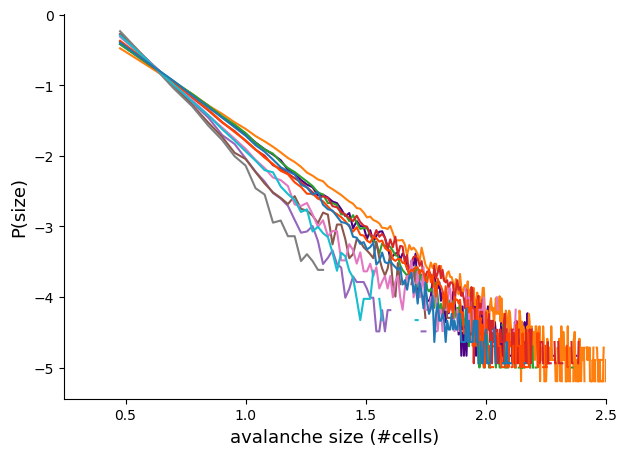

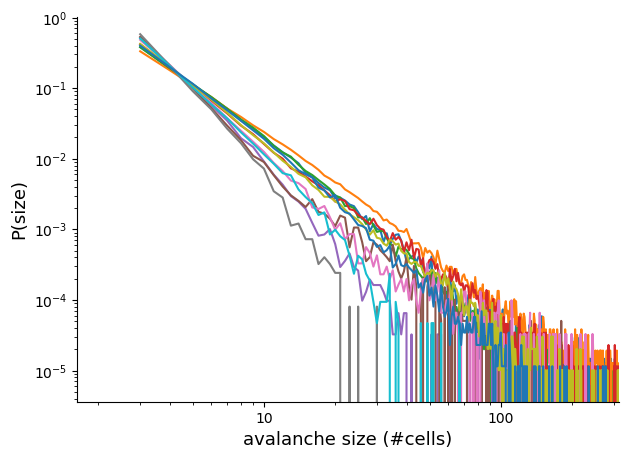

In [9]:
import matplotlib
fig, axarr = plt.subplots(figsize = (7,5))
colors = ['indigo', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'orangered', '#17becf', '#1f77b4']
axarr.set_prop_cycle('color', colors)
binvec = []
for i in range(len(blnlist)):
    binvec = np.append(binvec, np.load(blnlist[i])[0])
mini = np.min(binvec)
maxi = np.max(binvec)
for i in range(len(blnlist)):
    avdistcut = np.load(blnlist[i])[0]
    binned=np.linspace(mini,maxi, 675000)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = np.log10(hist[1][:-1])
    yaxis = np.log10(hist[0]/np.sum(hist[0]))
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.xlim(right = 2.5)  
plt.show()

fig, axarr = plt.subplots(figsize = (7,5))
binvec = []
for i in range(len(blnlist)):
    binvec = np.append(binvec, np.load(blnlist[i])[0])
mini = np.min(binvec)
maxi = np.max(binvec)
for i in range(len(blnlist)):
    avdistcut = np.load(blnlist[i])[0]
    binned=np.linspace(mini,maxi, 675000)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlim(right = 316)  
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/domini

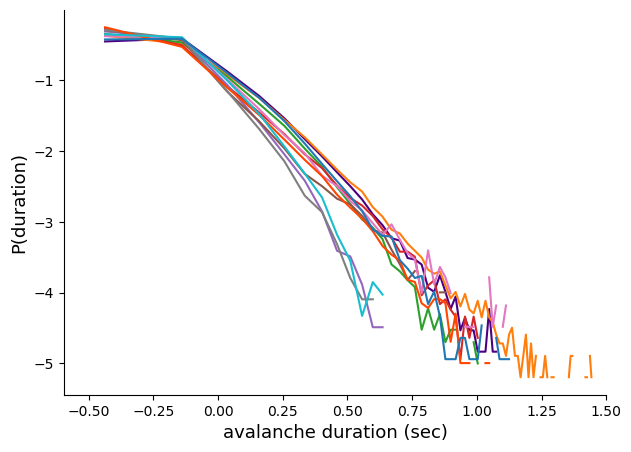

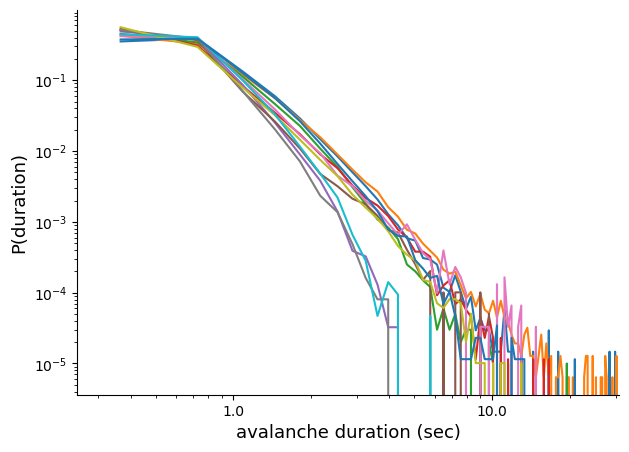

In [11]:
fig, axarr = plt.subplots(figsize = (7,5))
colors = ['indigo', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'orangered', '#17becf', '#1f77b4']
axarr.set_prop_cycle('color', colors)
binvec = []
for i in range(len(blnlist)):
    binvec = np.append(binvec, (1/2.73)*np.load(blnlist[i])[1])
mini = np.min(binvec)
maxi = np.max(binvec)
for i in range(len(blnlist)):
    avdistcut = (1/2.73)*np.load(blnlist[i])[1]
    binned=np.linspace(mini,maxi, 2500)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = np.log10(hist[1][:-1])
    yaxis = np.log10(hist[0]/np.sum(hist[0]))
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_ylabel('P(duration)', size = '13')
axarr.set_xlabel('avalanche duration (sec)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.xlim(right = 1.5)  
plt.show()

fig, axarr = plt.subplots(figsize = (7,5))
binvec = []
for i in range(len(blnlist)):
    binvec = np.append(binvec, (1/2.73)*np.load(blnlist[i])[1])
mini = np.min(binvec)
maxi = np.max(binvec)
for i in range(len(blnlist)):
    avdistcut = (1/2.73)*np.load(blnlist[i])[1]
    binned=np.linspace(mini,maxi, 2500)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlim(right = 31)  
axarr.set_ylabel('P(duration)', size = '13')
axarr.set_xlabel('avalanche duration (sec)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

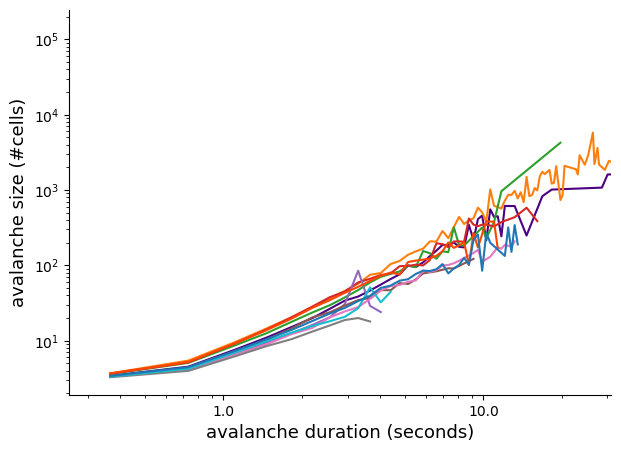

In [12]:
fig, axarr = plt.subplots(figsize = (7,5))
colors = ['indigo', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'orangered', '#17becf', '#1f77b4']
axarr.set_prop_cycle('color', colors)
sizelist, durlist = list(range(len(blnlist))),list(range(len(blnlist)))

for i in range(len(blnlist)):    
    avsize = np.load(blnlist[i])[0]
    avdur = (1/2.73)*np.load(blnlist[i])[1]
    sizevec, durvec = [],[]
    for e in np.unique(avdur):
        sizevec = np.append(sizevec, np.mean(avsize[np.where(avdur == e)]))  
        durvec = np.append(durvec, e)
    sizelist[i], durlist[i] = sizevec, durvec
for i in range(len(sizelist)):
    xaxis = np.unique(durlist[i])
    yaxis = sizelist[i]
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xlabel('avalanche duration (seconds)', size = '13')
axarr.set_ylabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.xlim(right = 31)  
plt.show()

### Baseline against nulls
* Null 1 - shuffle all - does a completely stochastic system generate avalanches?
* Null 2 - neighbour swap - is the local structure of active units important for generating avalanches?
* Null 3 - phase slide - is the temporal synchrony of local units required for avalanches?
* Null 4 - autocorrelation remove - is the signal memory of each active unit required for activity to spread? 

In [13]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))
swaplist = sorted(glob.glob('*BLN*swap*'))
shufflelist = sorted(glob.glob('*BLN*shuff*'))
slidelist = sorted(glob.glob('*BLN*slide*'))
autolist = sorted(glob.glob('*BLN*auto*'))

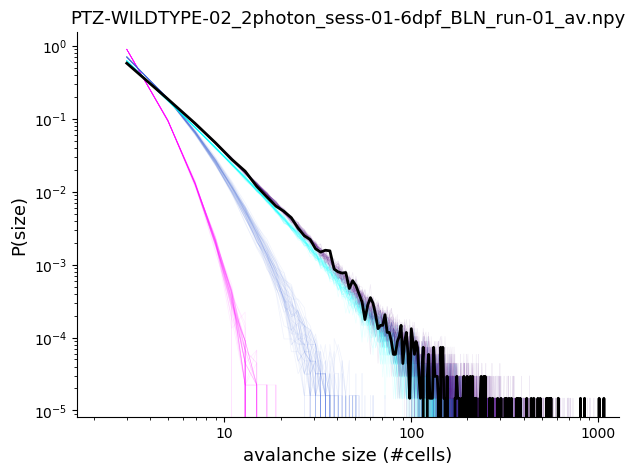

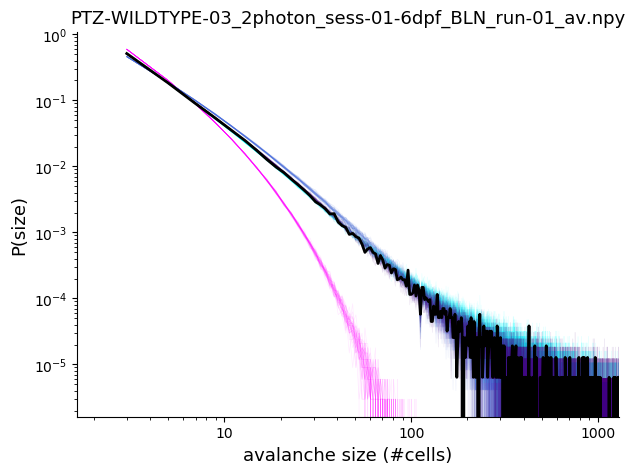

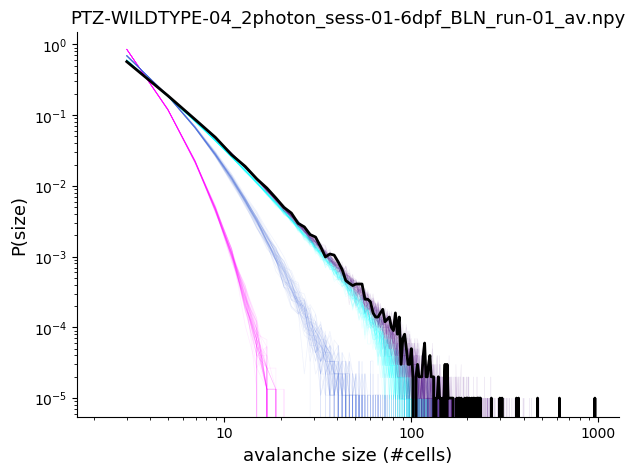

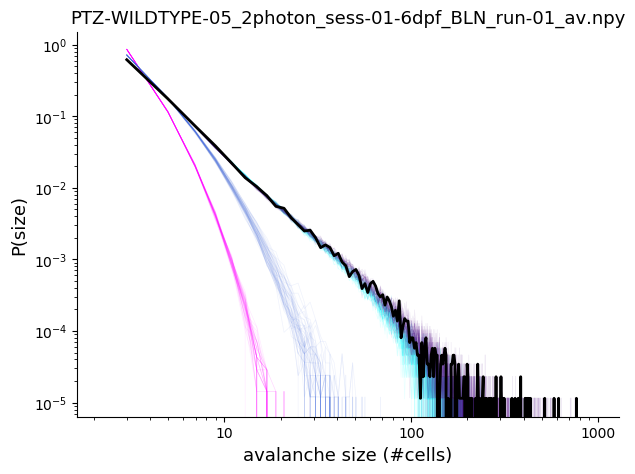

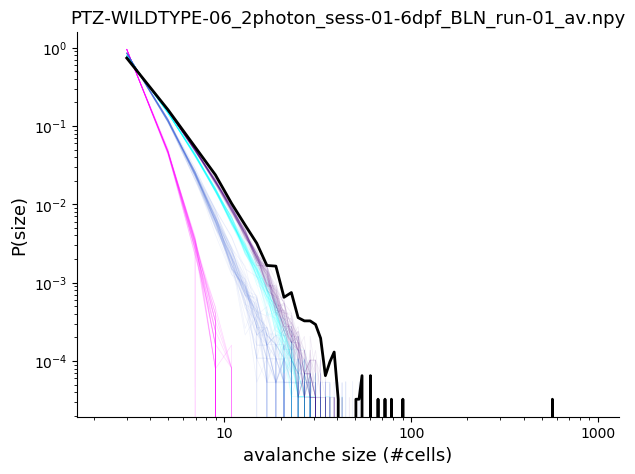

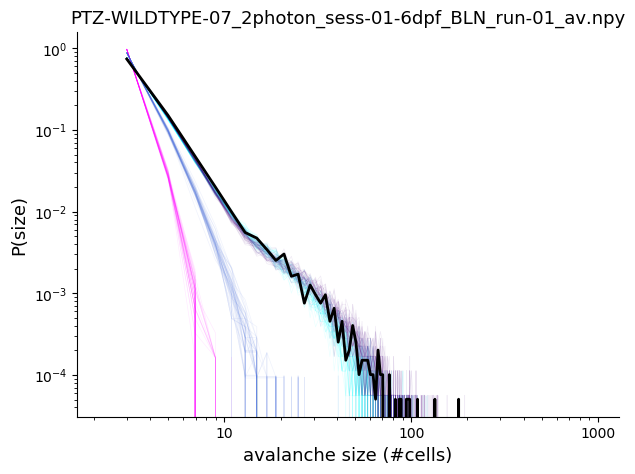

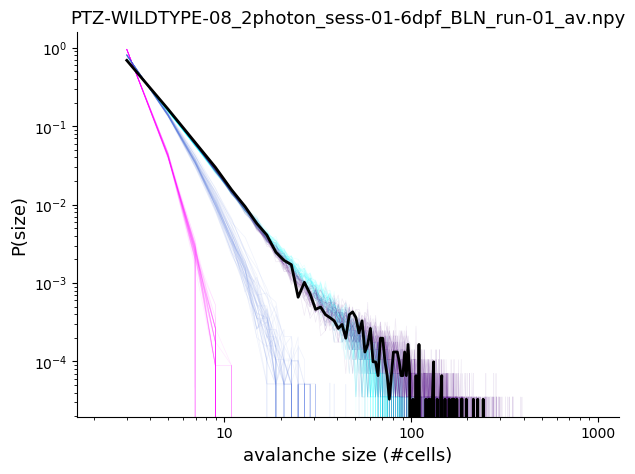

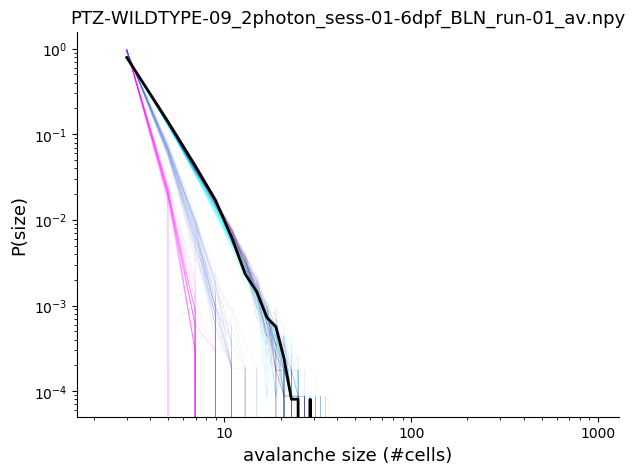

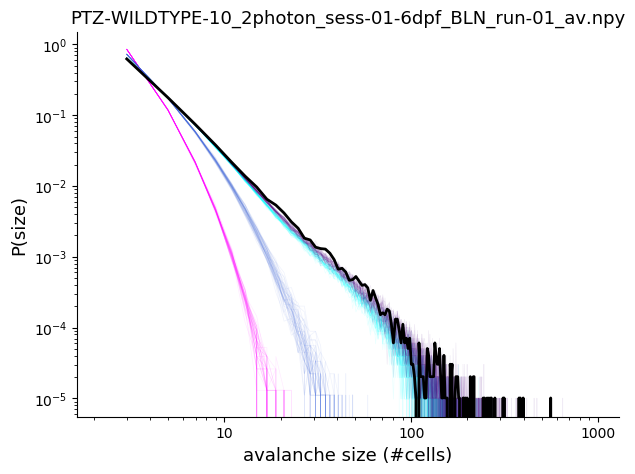

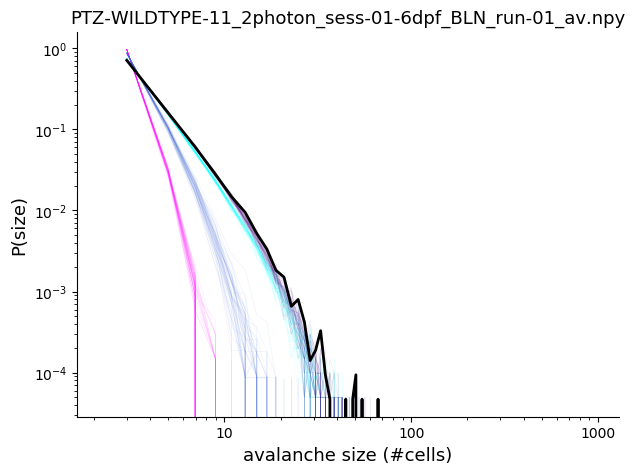

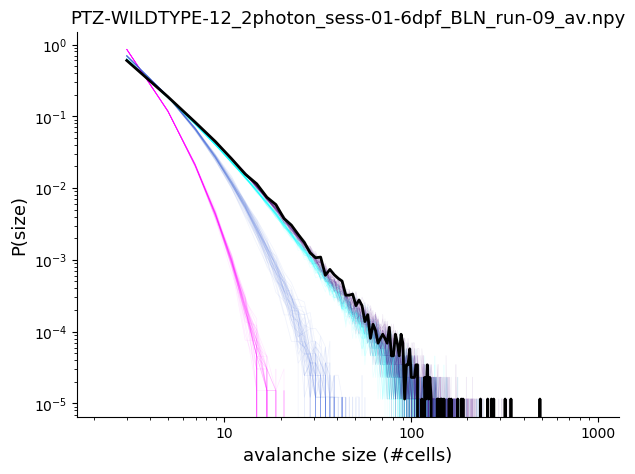

In [15]:
num1 = adfn.name_zero('front',2,12,1)
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
nbins = 340000
binvec = np.load(Fdrop + 'Project/' + experiment + os.sep + 'size_bln_null_combvec.npy')
maxi, mini = np.max(binvec), np.min(binvec)
for i in num1:
    os.chdir(Fdrop + 'Project/' + experiment)
    blnlist = sorted(glob.glob('*E-' + i + '*BLN*_av.npy*'))
    swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
    shufflelist = sorted(glob.glob('*E-' + i + '*BLN*shuff*'))
    slidelist = sorted(glob.glob('*E-' + i + '*BLN*slide*'))
    autolist = sorted(glob.glob('*E-' + i + '*BLN*auto*'))
    fig, axarr = plt.subplots(figsize = (7,5))
    shuffvec, swapvec, slidevec, autovec =[],[],[],[]
    veclist = [shuffvec, swapvec, autovec, slidevec]
    nulist = [shufflelist, swaplist, autolist, slidelist]
    for e in range(len(veclist)):
        for t in range(len(nulist[e])):
            binned = np.linspace(mini,maxi,nbins)
            hist = np.histogram(np.load(nulist[e][t])[0], bins = binned)
            xaxis = hist[1][:-1]
            yaxis = hist[0]/np.sum(hist[0])
            axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 0.5, markersize = 1, alpha = 0.08, c = colors[e+1])
    avdistcut = np.load(blnlist[0])[0]
    binned=np.linspace(mini,maxi, nbins)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, c = colors[0])
    axarr.set_xscale('log')
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim(right = 1300)  
    #plt.ylim(bottom = 0.000005)  
    axarr.set_title(str(blnlist[0]), size = '13')
    axarr.set_ylabel('P(size)', size = '13')
    axarr.set_xlabel('avalanche size (#cells)', size = '13')
    axarr.spines['top'].set_visible(False)
    axarr.spines['right'].set_visible(False)
    plt.show()

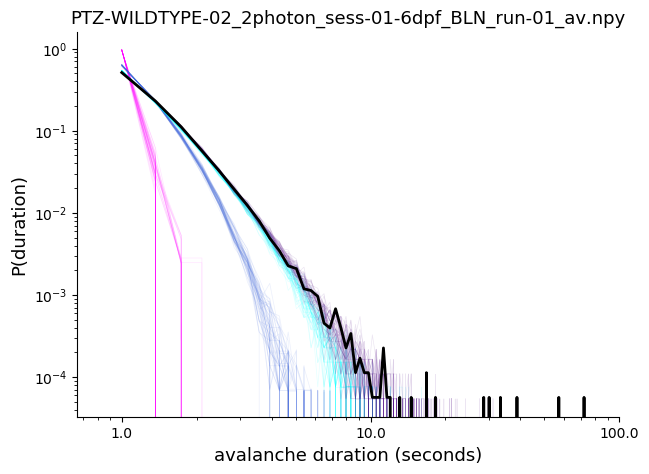

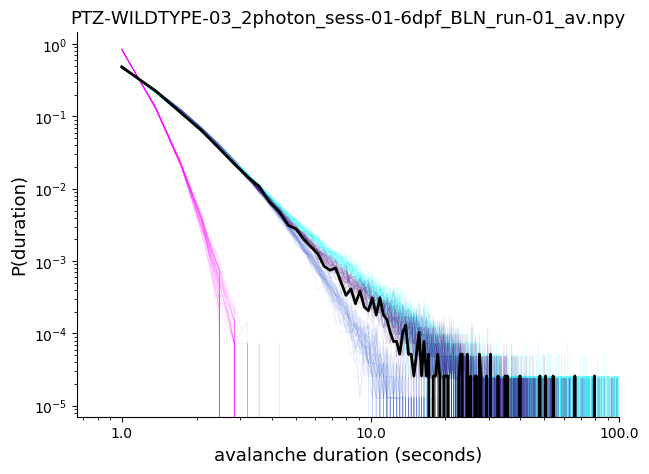

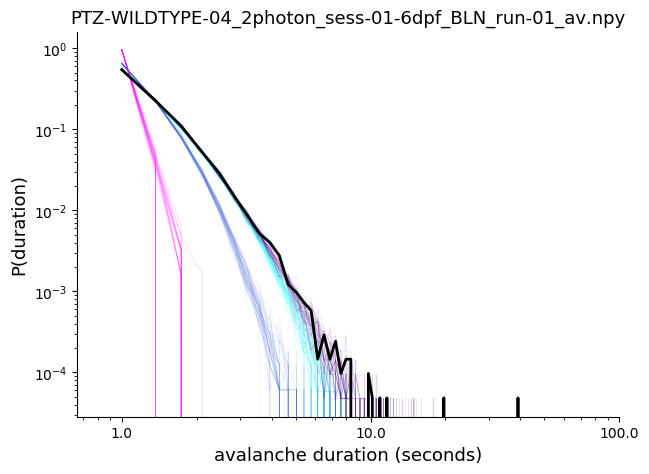

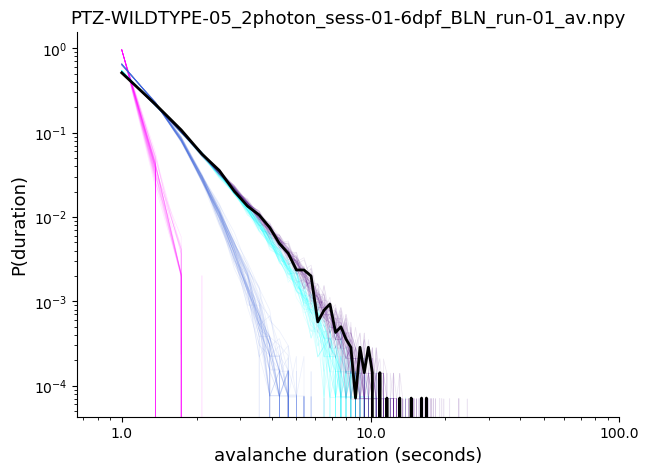

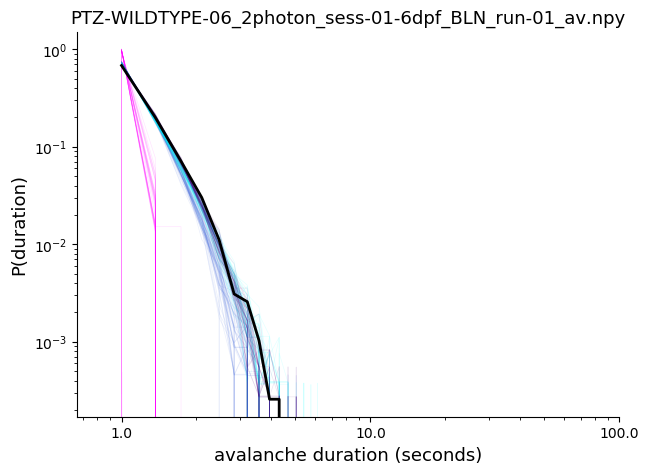

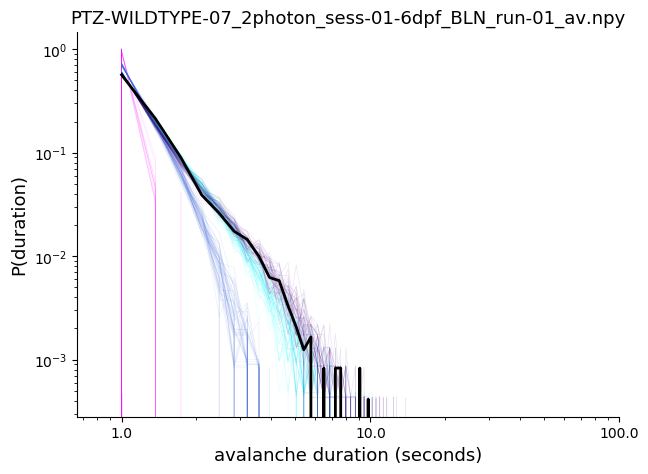

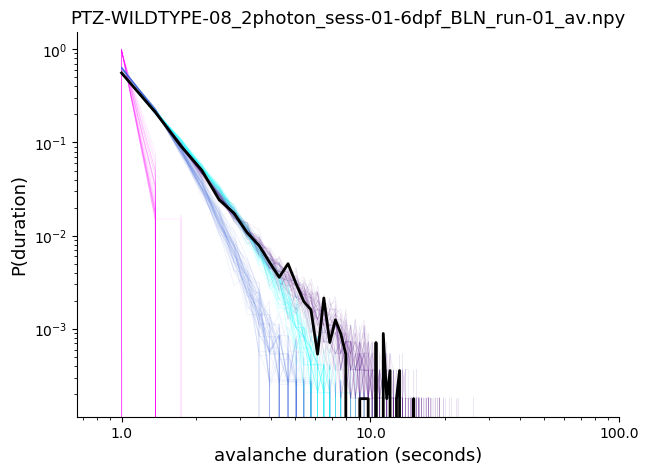

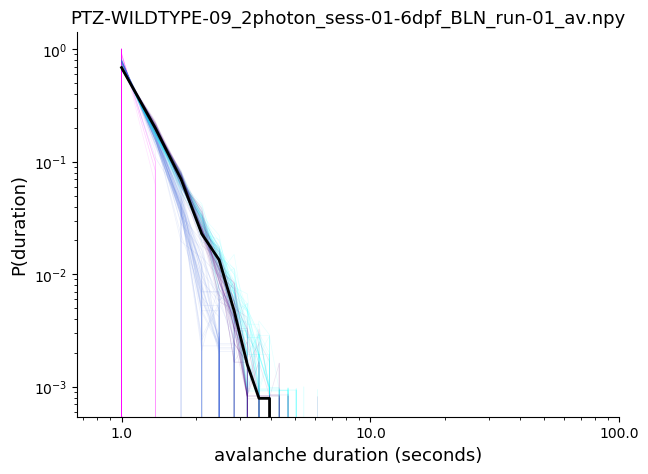

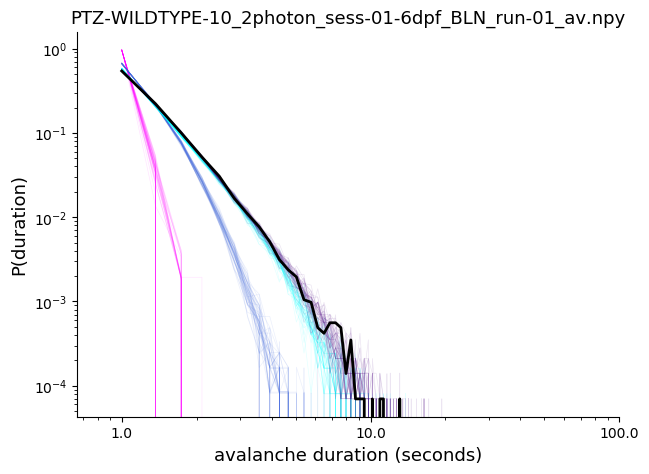

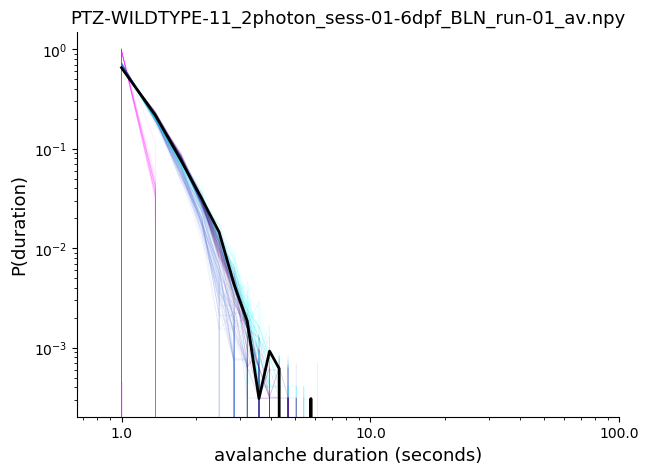

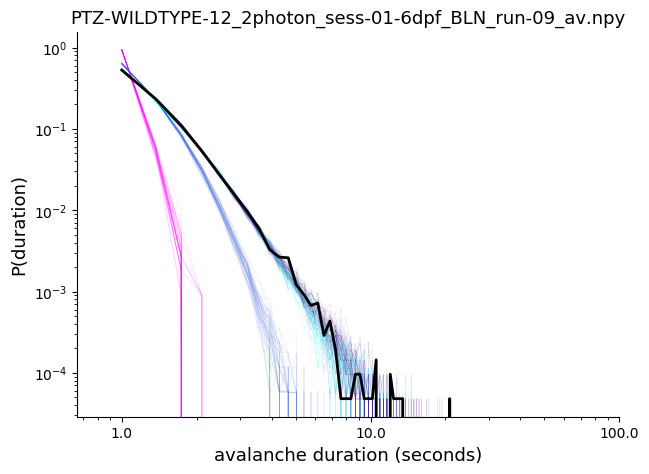

In [16]:
num1 = adfn.name_zero('front',2,12,1)
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
nbins = 11200
dur_binvec = np.load(Fdrop + 'Project/' + experiment + os.sep + 'dur_bln_null_combvec.npy')
maxi, mini = np.max(dur_binvec), np.min(dur_binvec)
for i in num1:
    os.chdir(Fdrop + 'Project/' + experiment)
    blnlist = sorted(glob.glob('*E-' + i + '*BLN*_av.npy*'))
    swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
    shufflelist = sorted(glob.glob('*E-' + i + '*BLN*shuff*'))
    slidelist = sorted(glob.glob('*E-' + i + '*BLN*slide*'))
    autolist = sorted(glob.glob('*E-' + i + '*BLN*auto*'))
    fig, axarr = plt.subplots(figsize = (7,5))
    frameon=False
    shuffvec, swapvec, slidevec, autovec =[],[],[],[]
    veclist = [shuffvec, swapvec, autovec, slidevec]
    nulist = [shufflelist, swaplist, autolist, slidelist]
    for e in range(len(veclist)):
        for t in range(len(nulist[e])):
            binned = np.linspace(mini,maxi,nbins)
            hist = np.histogram((1/2.73)*np.load(nulist[e][t])[1], bins = binned)
            xaxis = hist[1][:-1]
            yaxis = hist[0]/np.sum(hist[0])
            axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 0.5, markersize = 1, alpha = 0.1, c = colors[e+1])
    avdistcut = (1/2.73)*np.load(blnlist[0])[1]
    binned=np.linspace(mini,maxi, nbins)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, c = colors[0])
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim(right = 100)  
    #plt.ylim(bottom = 0.000005)  
    axarr.set_title(str(blnlist[0]), size = '13')
    axarr.set_ylabel('P(duration)', size = '13')
    axarr.set_xlabel('avalanche duration (seconds)', size = '13')
    axarr.spines['top'].set_visible(False)
    axarr.spines['right'].set_visible(False)
    plt.show()

### ks distance/exponent calculation
* for each fish - generate an average distribution, find ks distance of each point to that distribution
* for each baseline, quantify how far the baseline deviaties from that value - plot that ks distance (significant if > 1.96 sd from null mean)

In [3]:
# PLOT - average whole brain fluorescence
#----------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
size_powlist = sorted(glob.glob('*BLN*size*_power*'))
size_loglist = sorted(glob.glob('*BLN*size*_log*'))
dur_powlist = sorted(glob.glob('*BLN*dur*_power*'))
dur_loglist = sorted(glob.glob('*BLN*dur*_log*'))
size_powlist

['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-06_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-07_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-08_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-09_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-10_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-11_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-12_2photon_sess-01-6dpf_BLN_run-09_size_marglik_power.npy']

In [51]:
def mean_distribution(distlist, choose):
    comb_vec = []
    for i in range(len(distlist)):
        comb_vec = np.append(comb_vec, np.load(distlist[i])[choose])
    av = np.unique(comb_vec, return_counts=True)[0]
    freq = (np.unique(comb_vec, return_counts=True)[1]/50).astype(int)
    mean_vec = []
    for e in range(freq.shape[0]):
        mean_vec = np.append(mean_vec, np.full(freq[e],av[e]))
    return(mean_vec)

from scipy import stats
def ks_compare(distlist, mean_dist, bln_dist, choose, shape):
    ks_p = np.zeros(2)
    ks = np.zeros(shape)
    for i in range(len(distlist)):
        ks[i] = stats.ks_2samp(mean_dist, np.load(distlist[i])[choose])[0]
    mean = np.mean(ks)
    sd = 1.96*np.std(ks)
    ks_diff = stats.ks_2samp(bln_dist[choose], mean_dist)[0]
    if ks_diff > mean + sd or ks_diff < mean - sd:
        p = 0
    else:
        p = 1
    ks_p = [ks_diff, p]
    return(ks_p)

In [54]:
#KS + EXP
from scipy import stats
ks_list = adfn.list_of_list(22,4)
nullexp_list, nullratio_list = adfn.list_of_list(22,4),adfn.list_of_list(22,4)
mode = [0,1]
count=0
for y in range(2):
    for i in num1:
        os.chdir(Fdrop + 'Project/' + experiment)
        bln = np.load(sorted(glob.glob('*E-' + i + '*BLN*_av.npy*'))[0])
        swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
        shufflelist = sorted(glob.glob('*E-' + i + '*BLN*shuff*'))
        autolist = sorted(glob.glob('*E-' + i + '*BLN*auto*'))
        slidelist = sorted(glob.glob('*E-' + i + '*BLN*slide*'))
        null_list = [shufflelist, swaplist,autolist,slidelist]
        for f in range(len(null_list)):
            mean_null = mean_distribution(null_list[f], mode[y])
            ks_list[count][f] = ks_compare(null_list[f], mean_null, bln, mode[y], len(null_list[f]))
            data = mean_null
            sizes=data
            M=len(sizes)
            a=min(sizes) #define xmin
            b=max(sizes) #define xmax
            npart = 2000 #number of particles - number of draws from prior distribution
            ln=IS_LN(npart)
            po=IS(npart)
            nullexp_list[count][f] = po[0]
            nullratio_list[count][f] = po[1]-ln[2]
        count+=1
        print('Done fish ' + str(i))

Done fish 02
Done fish 03
Done fish 04
Done fish 05
Done fish 06
Done fish 07
Done fish 08
Done fish 09
Done fish 10
Done fish 11
Done fish 12
Done fish 02
Done fish 03
Done fish 04
Done fish 05
Done fish 06
Done fish 07
Done fish 08
Done fish 09
Done fish 10
Done fish 11
Done fish 12


In [69]:
#DATA FRAME
import pandas as pd
null_labels = ['Time + Cell shuffle', 'Cell shuffle','Time shuffle', 'Time permute']
ks_bynull = adfn.list_of_list(4,0)
blnexp_list = list(range(11))
ks_stack,p_stack,label_stack, expdiff_stack = [],[],[],[]
size_ks_df = {}
for i in range(len(null_labels)):
    for t in range(11):
        ks_stack = np.append(ks_stack, ks_list[t][i][0])
        p_stack = np.append(p_stack, ks_list[t][i][1])
        label_stack = np.append(label_stack, null_labels[i])
        blnexp_list[t] = np.load(size_powlist[t],allow_pickle=True)[0]
        expdiff_stack = np.append(expdiff_stack, (nullexp_list[t][i] - blnexp_list[t])) 
size_ks_df = pd.DataFrame({"KS distance":ks_stack , "p-value": p_stack, "Exponent change": expdiff_stack, "Labels": label_stack})

ks_stack,p_stack,label_stack, expdiff_stack = [],[],[],[]
for i in range(len(null_labels)):
    for t in range(11):
        ks_stack = np.append(ks_stack, ks_list[t+11][i][0])
        p_stack = np.append(p_stack, ks_list[t+11][i][1])
        label_stack = np.append(label_stack, null_labels[i])
        blnexp_list[t] = np.load(dur_powlist[t],allow_pickle=True)[0]
        expdiff_stack = np.append(expdiff_stack, (nullexp_list[t+11][i] - blnexp_list[t])) 
dur_ks_df = pd.DataFrame({"KS distance":ks_stack , "p-value": p_stack, "Exponent change": expdiff_stack, "Labels": label_stack})


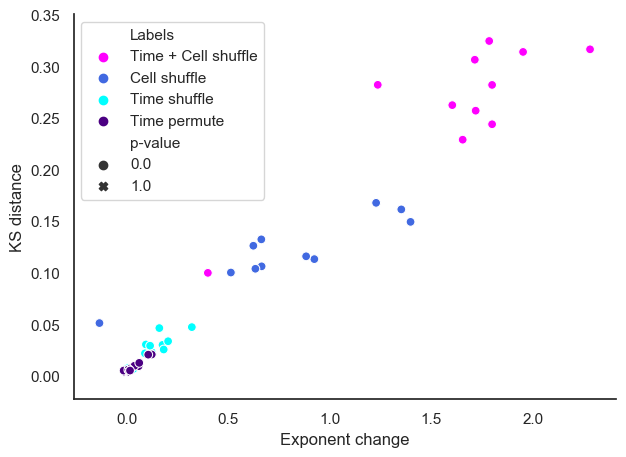

In [83]:
sns.set(style="white")
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
colors2 = ['black', 'black', 'black', 'black']
fig, ax = plt.subplots(figsize = (7,5))
ax = sns.scatterplot(x="Exponent change", y="KS distance",data=size_ks_df, hue='Labels', style = 'p-value', palette = colors[1:], alpha =1, s=40)
#ax = sns.pointplot(x="Labels", y="KS distance",data=ks_df[:44],  palette = colors[1:], ci = "sd")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

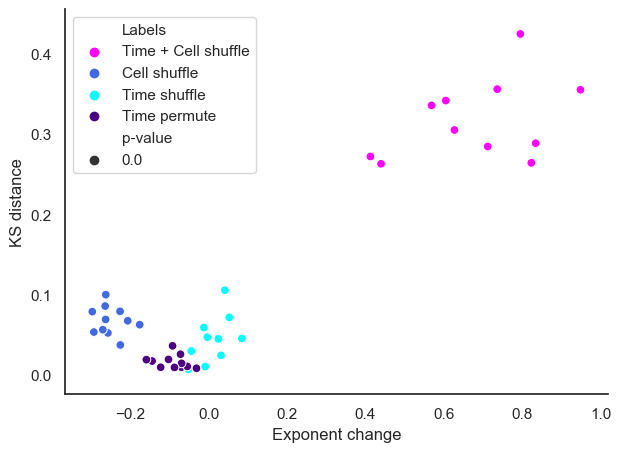

In [84]:
sns.set(style="white")
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
colors2 = ['black', 'black', 'black', 'black']
fig, ax = plt.subplots(figsize = (7,5))
ax = sns.scatterplot(x="Exponent change", y="KS distance",data = dur_ks_df, hue='Labels', style = 'p-value', palette = colors[1:], alpha =1, s=40)
#ax = sns.pointplot(x="Labels", y="KS distance",data=ks_df[:44],  palette = colors[1:], ci = "sd")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.ylim(0, 0.46)
plt.show()

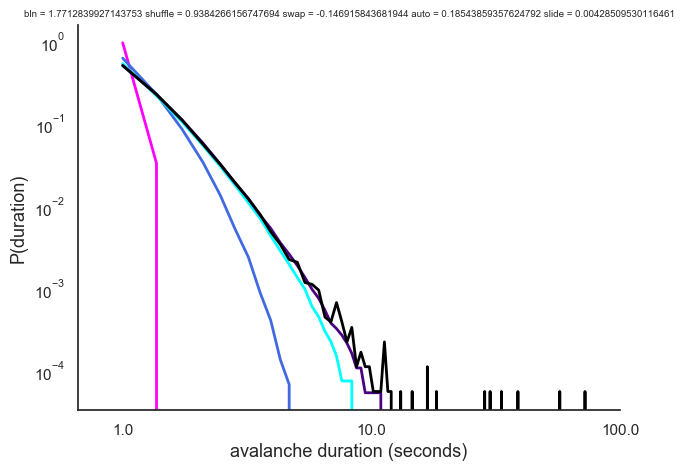

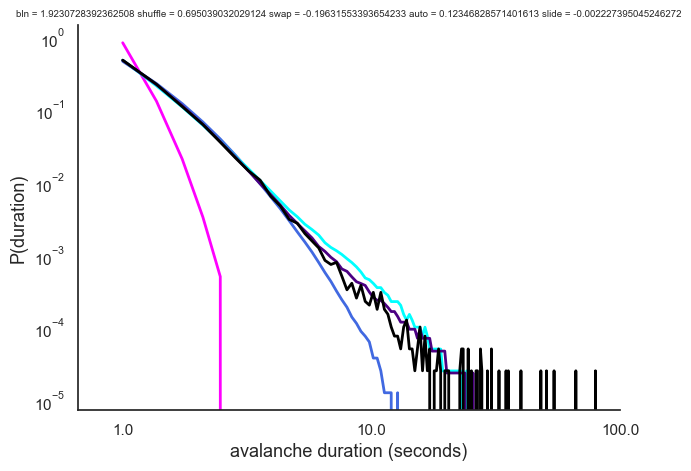

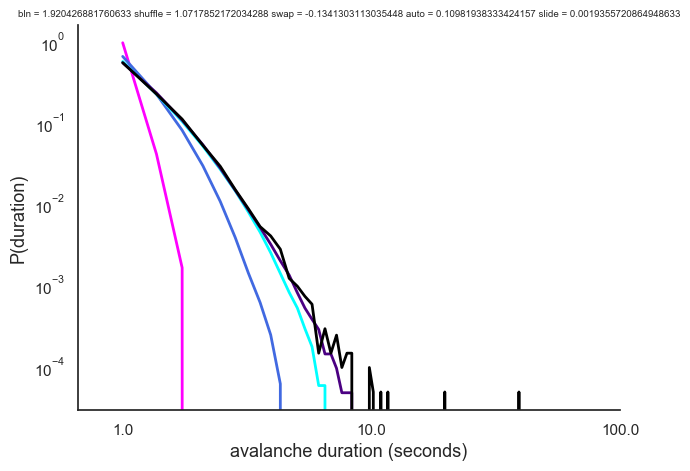

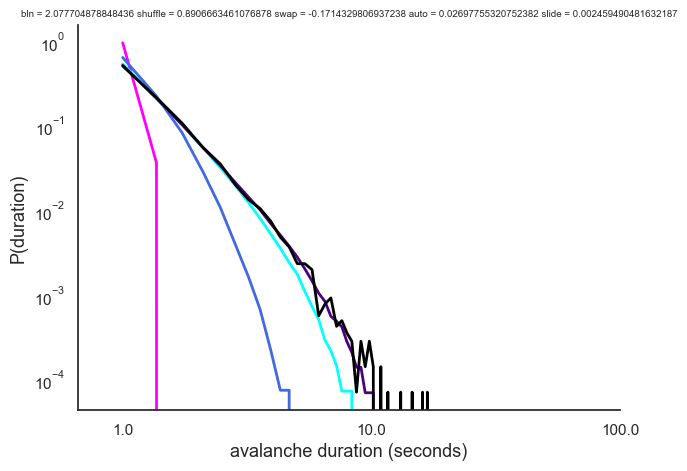

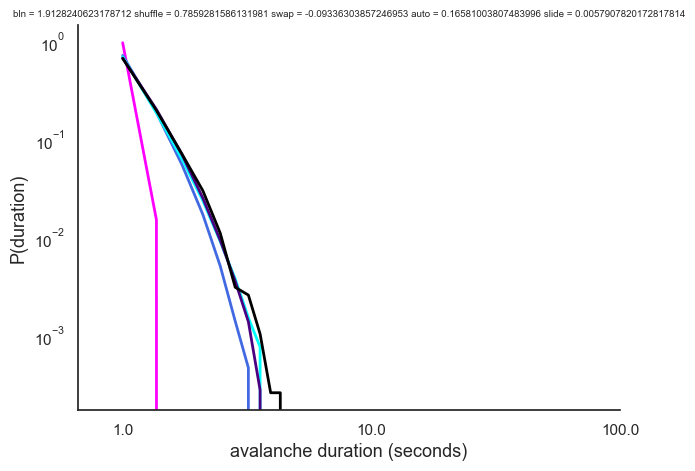

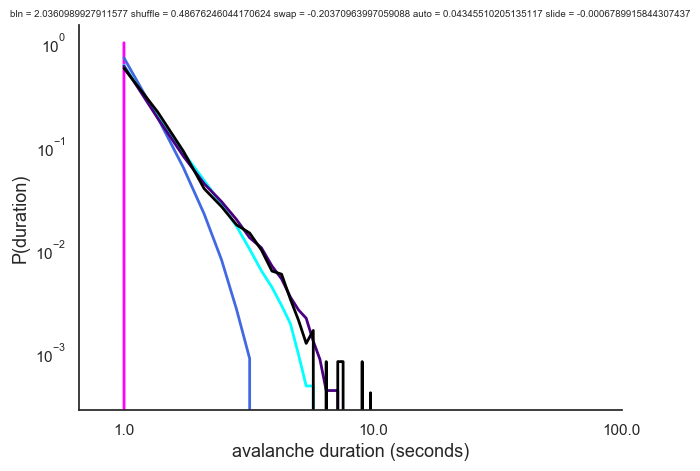

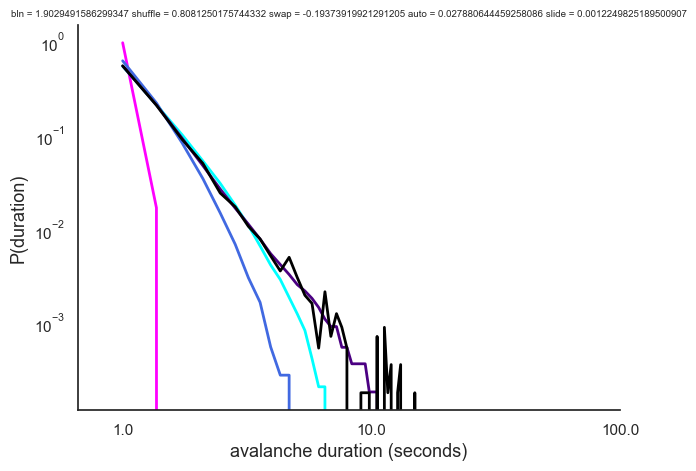

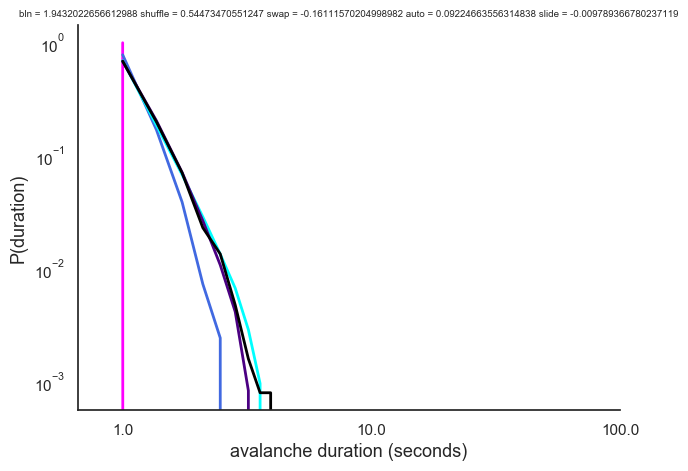

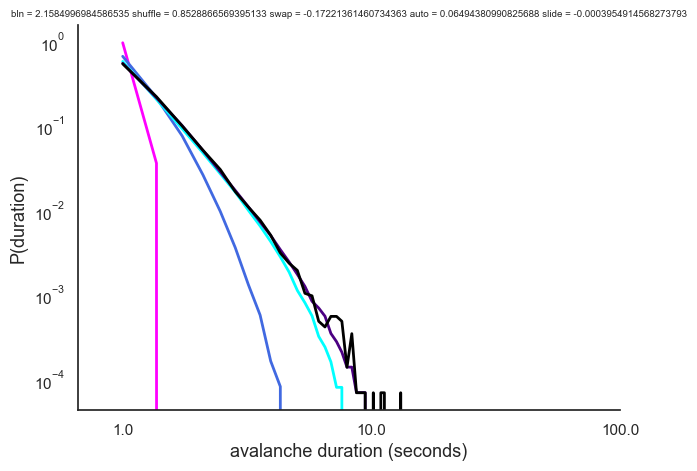

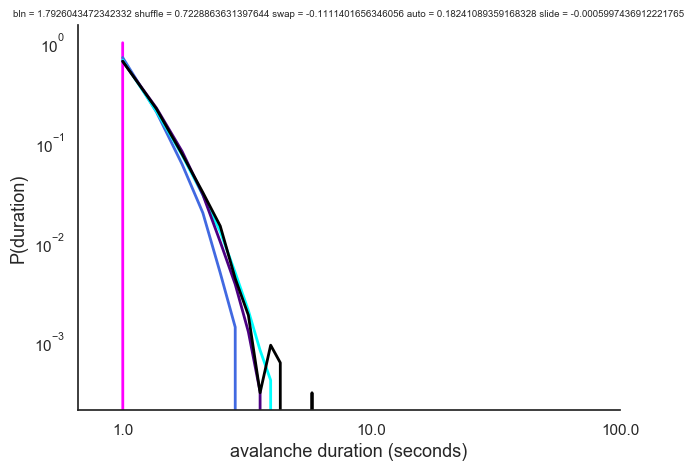

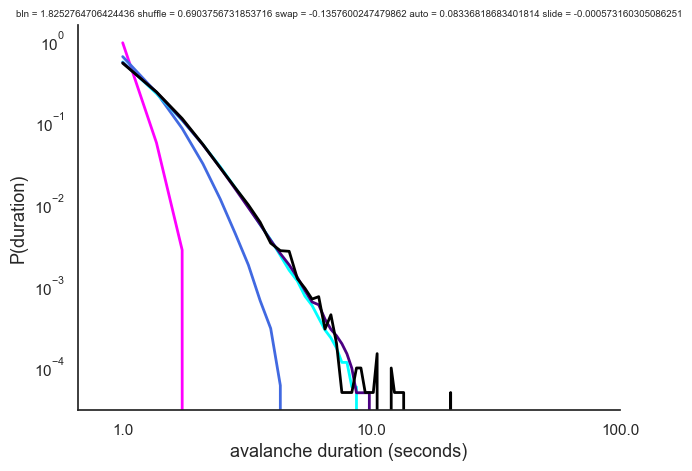

In [46]:
num1 = adfn.name_zero('front',2,12,1)
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
nbins = 11200
dur_binvec = np.load(Fdrop + 'Project/' + experiment + os.sep + 'dur_bln_null_combvec.npy')
maxi, mini = np.max(dur_binvec), np.min(dur_binvec)
for i in num1:
    os.chdir(Fdrop + 'Project/' + experiment)
    blnlist = sorted(glob.glob('*E-' + i + '*BLN*_av.npy*'))
    swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
    shufflelist = sorted(glob.glob('*E-' + i + '*BLN*shuff*'))
    slidelist = sorted(glob.glob('*E-' + i + '*BLN*slide*'))
    autolist = sorted(glob.glob('*E-' + i + '*BLN*auto*'))
    fig, axarr = plt.subplots(figsize = (7,5))
    frameon=False
    nulist = [shufflelist, swaplist, autolist, slidelist]
    ok = np.zeros(4)
    count=0
    for e in range(len(nulist)):
        null_comb = []
        for t in range(len(nulist[e])):
            null_comb = np.append(null_comb, np.load(nulist[e][t])[1]) 
        dur = np.unique(null_comb, return_counts=True)[0]
        counts = (np.unique(null_comb, return_counts=True)[1]/50).astype(int)
        mean_vec = []
        for x in range(counts.shape[0]):
            mean_vec = np.append(mean_vec, np.full(counts[x],dur[x]))
            
        binned = np.linspace(mini,maxi,nbins)
        hist = np.histogram((1/2.73)*mean_vec, bins = binned)
        xaxis = hist[1][:-1]
        yaxis = hist[0]/np.sum(hist[0])
        axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, c = colors[e+1])
        data = mean_vec
        sizes=data
        M=len(sizes)
        a=min(sizes) #define xmin
        b=max(sizes) #define xmax
        npart = 2000 #number of particles - number of draws from prior distribution
        ln=IS_LN(npart)
        po=IS(npart)
        ok[count] = po[0]
        count+=1
    avdistcut = (1/2.73)*np.load(blnlist[0])[1]
    binned=np.linspace(mini,maxi, nbins)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, c = colors[0])
    data = mean_vec
    sizes=data
    M=len(sizes)
    a=min(sizes) #define xmin
    b=max(sizes) #define xmax
    npart = 2000 #number of particles - number of draws from prior distribution
    ln=IS_LN(npart)
    po=IS(npart)
    bop = po[0]
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim(right = 100)  
    #plt.ylim(bottom = 0.000005)  
    axarr.set_title('bln = ' + str(bop) + ' shuffle = ' + str(ok[0]-bop) + ' swap = ' + str(ok[1]-bop) + ' auto = ' + str(ok[2]-bop) + ' slide = ' + str(ok[3]-bop), size = '7')
    axarr.set_ylabel('P(duration)', size = '13')
    axarr.set_xlabel('avalanche duration (seconds)', size = '13')
    axarr.spines['top'].set_visible(False)
    axarr.spines['right'].set_visible(False)
    plt.show()

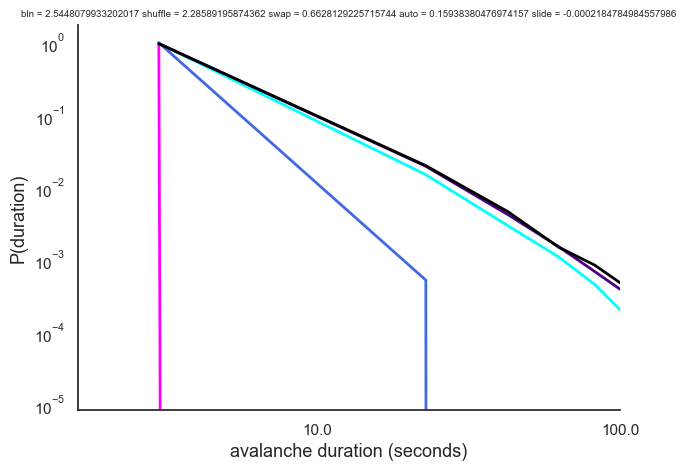

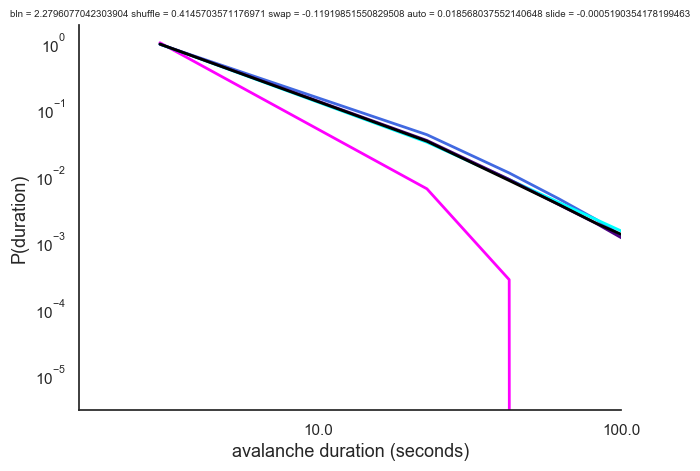

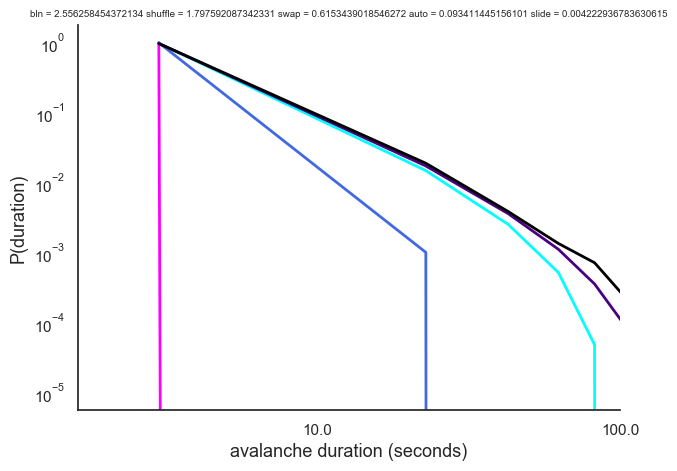

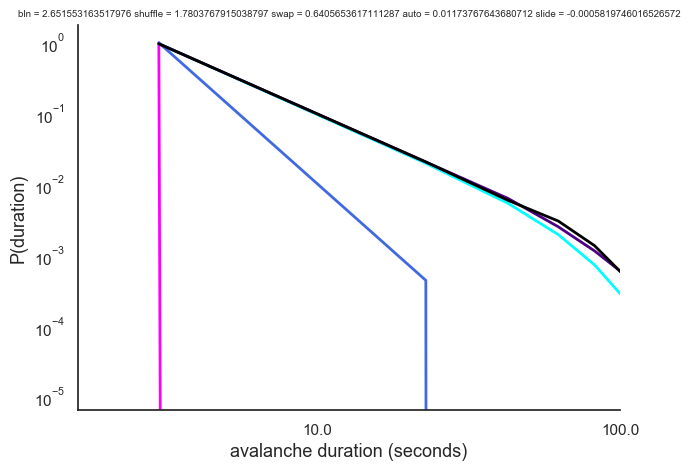

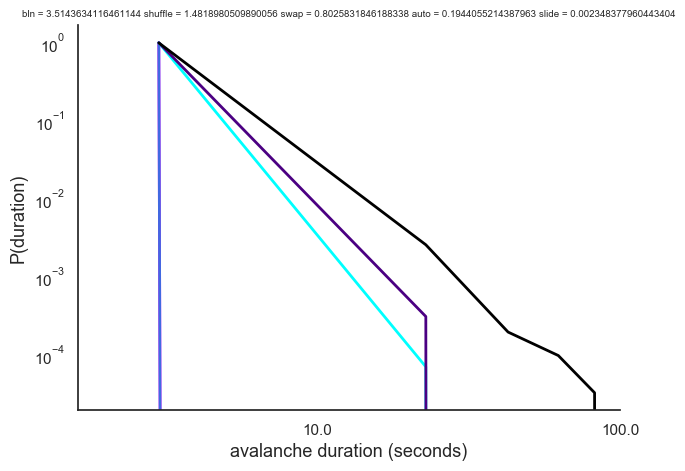

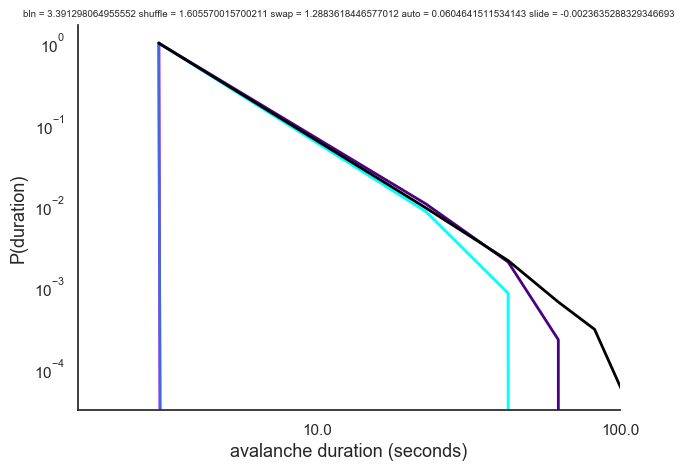

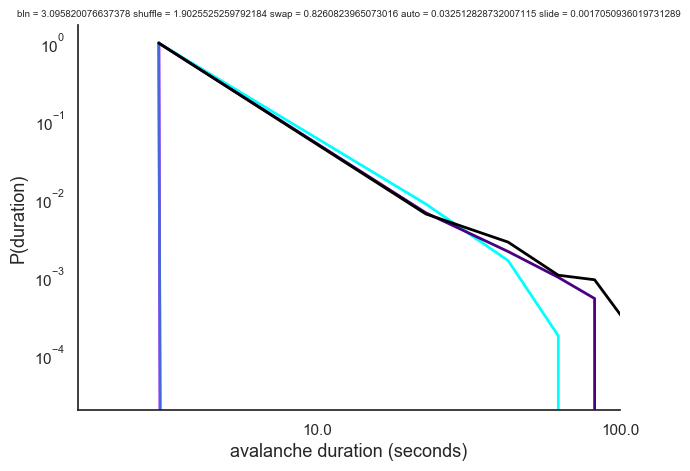

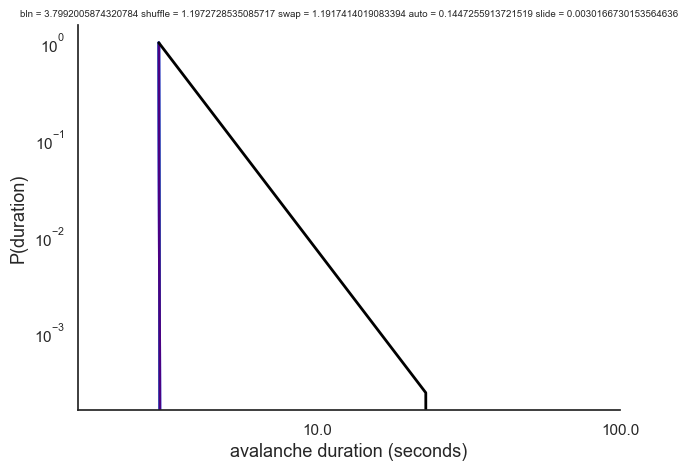

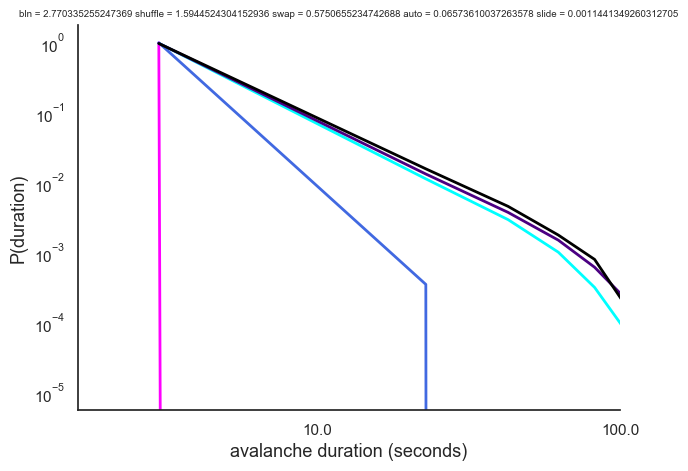

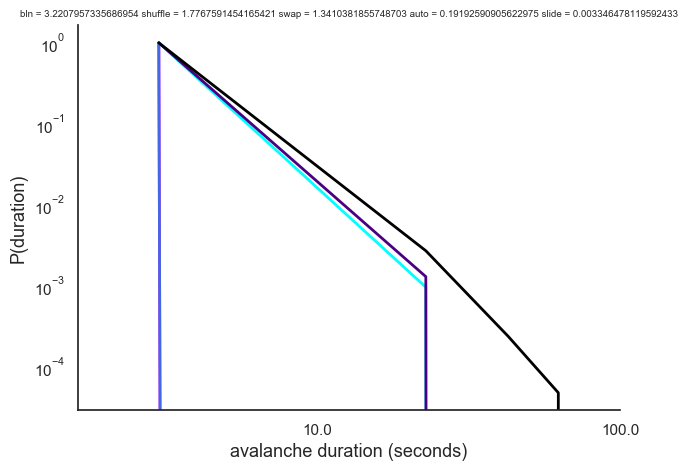

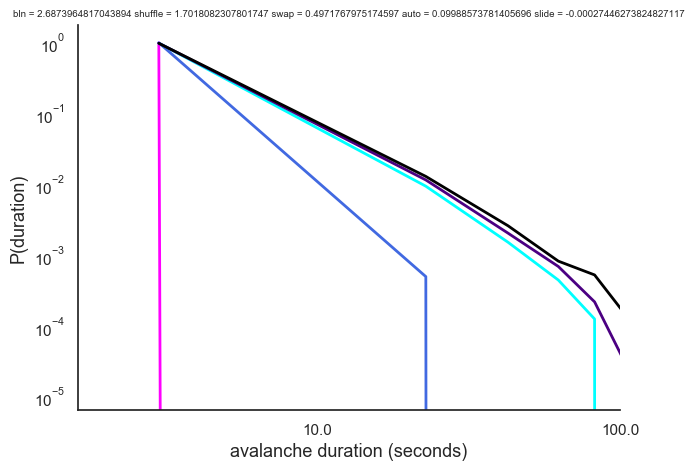

In [47]:
num1 = adfn.name_zero('front',2,12,1)
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
nbins = 34000

maxi, mini = np.max(binvec), np.min(binvec)
for i in num1:
    os.chdir(Fdrop + 'Project/' + experiment)
    blnlist = sorted(glob.glob('*E-' + i + '*BLN*_av.npy*'))
    swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
    shufflelist = sorted(glob.glob('*E-' + i + '*BLN*shuff*'))
    slidelist = sorted(glob.glob('*E-' + i + '*BLN*slide*'))
    autolist = sorted(glob.glob('*E-' + i + '*BLN*auto*'))
    fig, axarr = plt.subplots(figsize = (7,5))
    frameon=False
    nulist = [shufflelist, swaplist, autolist, slidelist]
    ok = np.zeros(4)
    count=0
    for e in range(len(nulist)):
        null_comb = []
        for t in range(len(nulist[e])):
            null_comb = np.append(null_comb, np.load(nulist[e][t])[0]) 
        dur = np.unique(null_comb, return_counts=True)[0]
        counts = (np.unique(null_comb, return_counts=True)[1]/50).astype(int)
        mean_vec = []
        for x in range(counts.shape[0]):
            mean_vec = np.append(mean_vec, np.full(counts[x],dur[x]))
            
        binned = np.linspace(mini,maxi,nbins)
        hist = np.histogram(mean_vec, bins = binned)
        xaxis = hist[1][:-1]
        yaxis = hist[0]/np.sum(hist[0])
        axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, c = colors[e+1])
        data = mean_vec
        sizes=data
        M=len(sizes)
        a=min(sizes) #define xmin
        b=max(sizes) #define xmax
        npart = 2000 #number of particles - number of draws from prior distribution
        ln=IS_LN(npart)
        po=IS(npart)
        ok[count] = po[0]
        count+=1
    avdistcut = np.load(blnlist[0])[0]
    binned=np.linspace(mini,maxi, nbins)
    hist = np.histogram(avdistcut, bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, c = colors[0])
    data = mean_vec
    sizes=data
    M=len(sizes)
    a=min(sizes) #define xmin
    b=max(sizes) #define xmax
    npart = 2000 #number of particles - number of draws from prior distribution
    ln=IS_LN(npart)
    po=IS(npart)
    bop = po[0]
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim(right = 100)  
    #plt.ylim(bottom = 0.000005)  
    axarr.set_title('bln = ' + str(bop) + ' shuffle = ' + str(ok[0]-bop) + ' swap = ' + str(ok[1]-bop) + ' auto = ' + str(ok[2]-bop) + ' slide = ' + str(ok[3]-bop), size = '7')
    axarr.set_ylabel('P(duration)', size = '13')
    axarr.set_xlabel('avalanche duration (seconds)', size = '13')
    axarr.spines['top'].set_visible(False)
    axarr.spines['right'].set_visible(False)
    plt.show()

In [71]:
count=0
prac_swapexp = np.zeros(11)
for i in num1:
    swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
    null_comb = []
    for t in range(len(swaplist)):
        null_comb = np.append(null_comb, np.load(swaplist[t])[1]) 
    
    dur = np.unique(null_comb, return_counts=True)[0]
    counts = (np.unique(null_comb, return_counts=True)[1]/50).astype(int)
    mean_vec = []
    for e in range(counts.shape[0]):
        mean_vec = np.append(mean_vec, np.full(counts[e],dur[e]))
        
    data = mean_vec
    sizes=data
    M=len(sizes)
    a=min(sizes) #define xmin
    b=max(sizes) #define xmax
    npart = 2000 #number of particles - number of draws from prior distribution
    ln=IS_LN(npart)
    po=IS(npart)
    prac_swapexp[count] = po[0]
    count+=1
    #np.save(Fdrop + 'Project/' + experiment + os.sep + adfn.name_template([avlist[0]], 'short') + '_dur_marglik_power.npy', po)
    #np.save(Fdrop + 'Project/' + experiment + os.sep + adfn.name_template([avlist[0]], 'short')  + '_dur_marglik_log.npy', ln)
    #print('Done fish ' + adfn.name_template([avlist[0]], 'short'))

array([ 1.,  1.,  1., ..., 11., 11., 12.])

In [ ]:
for f in range(len(null_list)):
    null_comb = []
    for t in range(len(null_list[f])):
        null_comb = np.append(null_comb, np.load(null_list[f][t])[choose]) 
                                  
    dur = np.unique(null_comb, return_counts=True)[0]
    counts = (np.unique(null_comb, return_counts=True)[1]/50).astype(int)
    mean_vec = []
    for e in range(counts.shape[0]):
        mean_vec = np.append(mean_vec, np.full(counts[e],dur[e]))

In [ ]:
num1 = adfn.name_zero('front',2,12,1)
for i in num1:
    avlist =  sorted(glob.glob('*E-' + str(i) + '*BLN*_av.npy'))
    data = np.load(avlist[0])
    sizes=data[0]
    M=len(sizes)
    a=min(sizes) #define xmin
    b=max(sizes) #define xmax
    npart = 2000 #number of particles - number of draws from prior distribution
    ln=IS_LN(npart)
    po=IS(npart)
    plotcomp(po[0],ln[0],ln[1])
    print('exp = ' + str(po[0]) + ' marglik = '  + str(po[1] - ln[2]))
    sizes=data[1]
    M=len(sizes)
    a=min(sizes) #define xmin
    b=max(sizes) #define xmax
    npart = 2000 #number of particles - number of draws from prior distribution
    ln=IS_LN(npart)
    po=IS(npart)
    plotcomp(po[0],ln[0],ln[1])
    print('exp = ' + str(po[0]) + ' marglik = '  + str(po[1] - ln[2]))

In [40]:
#SIZE
from scipy import stats
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))
size_fishlist = list(range(len(blnlist)))
count=0
for i in num1:
    ks3 = list(range(4))
    os.chdir(Fdrop + 'Project/' + experiment)
    blnlist = sorted(glob.glob('*E-' + i + '*BLN*_av.npy*'))
    swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
    shufflelist = sorted(glob.glob('*E-' + i + '*BLN*shuff*'))
    slidelist = sorted(glob.glob('*E-' + i + '*slide*'))
    autolist = sorted(glob.glob('*E-' + i + '*auto*'))
    null_list = [shufflelist, swaplist, slidelist,autolist]
    for f in range(len(null_list)):
        ks1 = np.zeros((2,50))
        for t in range(len(swaplist)):
            ks1[:,t] = stats.ks_2samp(np.load(blnlist[0])[0], np.load(null_list[f][t])[0])
        ks3[f] = ks1
    size_fishlist[count] = ks3
    count+=1

In [43]:
import pandas as pd
import seaborn as sns

ks_vec, label_vec, p_vec = [],[],[]
null_labels = ['Time + Cell shuffle', 'Cell shuffle','Time permute', 'Time shuffle' ]
for i in range(len(size_fishlist)):
    count = 0
    for e in range(0,4):
        ks_vec = np.append(ks_vec, size_fishlist[i][e][0])
        label_vec = np.append(label_vec, adfn.repeat_list(null_labels[count], 50))
        p_vec =  np.append(p_vec, size_fishlist[i][e][1])
        count+=1

df = pd.DataFrame({"KS distance":ks_vec , 'p-value': p_vec, 'significant': p_vec < 0.05, "Labels": label_vec})

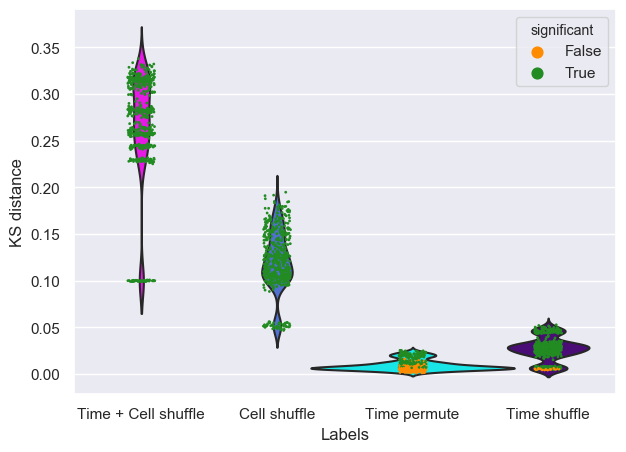

In [44]:
sns.set(style="darkgrid")
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
colors2 = ['darkorange', 'forestgreen']
fig, ax = plt.subplots(figsize = (7,5))
ax = sns.violinplot(x="Labels", y="KS distance", data=df,
                    inner=None, color="0.1", width = 1.5,  palette = colors[1:], saturation = 0.8)
#ax = sns.set(font_scale = 1.3)
ax = sns.stripplot(x="Labels", y="KS distance", hue = "significant", data=df, size = 2, alpha = 1, jitter = True, palette = colors2)
plt.show()

In [45]:
df

KS distance       p-value  significant               Labels
0        0.316608  0.000000e+00         True  Time + Cell shuffle
1        0.316069  0.000000e+00         True  Time + Cell shuffle
2        0.316930  0.000000e+00         True  Time + Cell shuffle
3        0.316231  0.000000e+00         True  Time + Cell shuffle
4        0.313244  0.000000e+00         True  Time + Cell shuffle
...           ...           ...          ...                  ...
2195     0.031764  1.540629e-38         True         Time shuffle
2196     0.030005  1.789527e-34         True         Time shuffle
2197     0.030658  5.211747e-36         True         Time shuffle
2198     0.030666  5.157628e-36         True         Time shuffle
2199     0.029200  1.272917e-32         True         Time shuffle

[2200 rows x 4 columns]

In [41]:
#DURATION
from scipy import stats
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))
dur_fishlist = list(range(len(blnlist)))
count=0
for i in num1:
    ks3 = list(range(4))
    os.chdir(Fdrop + 'Project/' + experiment)
    blnlist = sorted(glob.glob('*E-' + i + '*BLN*_av.npy*'))
    swaplist = sorted(glob.glob('*E-' + i + '*BLN*swap*'))
    shufflelist = sorted(glob.glob('*E-' + i + '*BLN*shuff*'))
    slidelist = sorted(glob.glob('*E-' + i + '*BLN*slide*'))
    autolist = sorted(glob.glob('*E-' + i + '*BLN*auto*'))
    null_list = [shufflelist, swaplist, slidelist,autolist]
    for f in range(len(null_list)):
        ks1 = np.zeros((2,50))
        for t in range(len(swaplist)):
            ks1[:,t] = stats.ks_2samp(np.load(blnlist[0])[1], np.load(null_list[f][t])[1])
        ks3[f] = ks1
    dur_fishlist[count] = ks3
    count+=1

In [46]:
import pandas as pd
import seaborn as sns

ks_vec, label_vec, p_vec = [],[],[]
labels = ['Time + Cell shuffle', 'Cell shuffle','Time permute', 'Time shuffle' ]
for i in range(len(dur_fishlist)):
    count = 0
    for e in range(0,4):
        ks_vec = np.append(ks_vec, dur_fishlist[i][e][0])
        label_vec = np.append(label_vec, adfn.repeat_list(labels[count], 50))
        p_vec =  np.append(p_vec, dur_fishlist[i][e][1])
        count+=1

df1 = pd.DataFrame({"KS distance":ks_vec , 'p-value': p_vec, 'significant': p_vec < 0.05, "Labels": label_vec})

In [47]:
df1

KS distance       p-value  significant               Labels
0        0.424596  0.000000e+00         True  Time + Cell shuffle
1        0.420849  0.000000e+00         True  Time + Cell shuffle
2        0.423354  0.000000e+00         True  Time + Cell shuffle
3        0.425161  0.000000e+00         True  Time + Cell shuffle
4        0.425024  0.000000e+00         True  Time + Cell shuffle
...           ...           ...          ...                  ...
2195     0.048454  4.100155e-89         True         Time shuffle
2196     0.047257  7.006468e-85         True         Time shuffle
2197     0.048359  5.852103e-89         True         Time shuffle
2198     0.047611  3.264977e-86         True         Time shuffle
2199     0.046644  1.399107e-82         True         Time shuffle

[2200 rows x 4 columns]

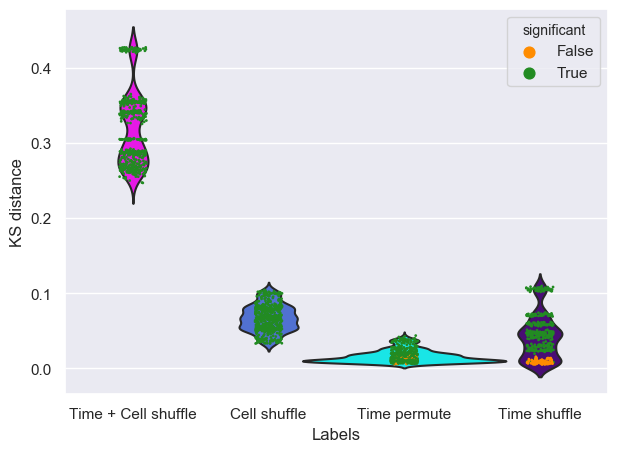

In [48]:
sns.set(style="darkgrid")
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
colors2 = ['darkorange', 'forestgreen']
fig, ax = plt.subplots(figsize = (7,5))
ax = sns.violinplot(x="Labels", y="KS distance", data=df1,
                    inner=None, color="0.1", width = 1.5,  palette = colors[1:], saturation = 0.8)
#ax = sns.set(font_scale = 1.3)
ax = sns.stripplot(x="Labels", y="KS distance", hue = "significant", data=df1, size = 2, alpha = 1, jitter = True, palette = colors2)
plt.show()

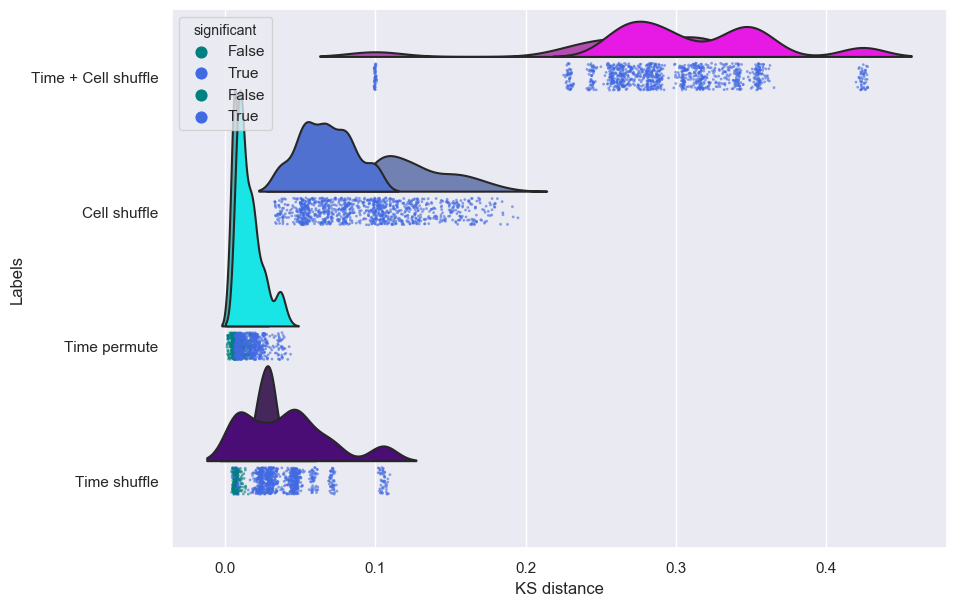

In [49]:
import ptitprince as pt
sns.set(style="darkgrid")
colors = ['black', 'magenta','royalblue','cyan', 'indigo']
colors2 = ['teal', 'royalblue']
widths = [8,8,3,4]
fig, ax = plt.subplots(figsize = (10,7))
ax = pt.half_violinplot(y="Labels", x="KS distance", data=df,
                    inner=None, color="0.1", width = 3.5,  palette = colors[1:], saturation = 0.4, orient = 'h', bw = 0.3, alpha = 0.1)
ax = pt.half_violinplot(y="Labels", x="KS distance", data=df1,
                    inner=None, color="0.1", width = 3.5,  palette = colors[1:], saturation = 0.8, orient = 'h', bw = 0.3)
#ax = sns.set(font_scale = 1.3)
ax = sns.stripplot(y="Labels", x="KS distance", hue = "significant", data=df, size = 2, alpha = 0.6, jitter = 1, palette = colors2, orient = 'h')
ax = sns.stripplot(y="Labels", x="KS distance", hue = "significant", data=df1, size = 2, alpha = 0.6, jitter = 1, palette = colors2, orient = 'h')
plt.show()

### Power law quantification (LLR, ks distance)

In [480]:
# PLOT - average whole brain fluorescence
#----------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
size_powlist = sorted(glob.glob('*BLN*size*_power*'))
size_loglist = sorted(glob.glob('*BLN*size*_log*'))
dur_powlist = sorted(glob.glob('*BLN*dur*_power*'))
dur_loglist = sorted(glob.glob('*BLN*dur*_log*'))
size_powlist

['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-06_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-07_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-08_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-09_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-10_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-11_2photon_sess-01-6dpf_BLN_run-01_size_marglik_power.npy',
 'PTZ-WILDTYPE-12_2photon_sess-01-6dpf_BLN_run-09_size_marglik_power.npy']

In [551]:
for i in num1:
    avlist =  sorted(glob.glob('*E-' + str(i) + '*BLN*_av.npy'))
    data = np.load(avlist[0])
    sizes=data[1]
    M=len(sizes)
    a=min(sizes) #define xmin
    b=max(sizes) #define xmax
    npart = 2000 #number of particles - number of draws from prior distribution
    ln=IS_LN(npart)
    po=IS(npart)
    np.save(Fdrop + 'Project/' + experiment + os.sep + adfn.name_template([avlist[0]], 'short') + '_dur_marglik_power.npy', po)
    np.save(Fdrop + 'Project/' + experiment + os.sep + adfn.name_template([avlist[0]], 'short')  + '_dur_marglik_log.npy', ln)
    print('Done fish ' + adfn.name_template([avlist[0]], 'short'))

Done fish PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-04_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-05_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-06_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-07_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-08_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-09_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-10_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-11_2photon_sess-01-6dpf_BLN_run-01
Done fish PTZ-WILDTYPE-12_2photon_sess-01-6dpf_BLN_run-09


In [625]:
sizexp_bln,durexp_bln = np.zeros(11), np.zeros(11)
for i in range(len(size_powlist)):
    sizexp_bln[i] = np.load(size_powlist[i],allow_pickle=True)[0]
    durexp_bln[i] = np.load(dur_powlist[i],allow_pickle=True)[0]

In [483]:
sizelikdic = {
  "size": size_power - size_log,
  "dur": dur_power - dur_log,
}

In [484]:
sizelikdic

{'size': array([23011.51617552, 55845.48248004, 31239.01224246, 36185.29979866,
         9072.72208186,  8382.75567954, 11807.94677697,  3321.88907279,
        37137.65570171,  6642.31951648, 26238.04349297]),
 'dur': array([112389.76946623, 298300.91658222, 205717.91378071, 204066.48183413,
         69088.41112788,  46144.05112085,  60396.49598363,  28889.82148949,
        241891.37454356,  44692.34478666, 153229.12493645])}

### Supplementary figure
* show different distributions and different calcium traces for different p firing values

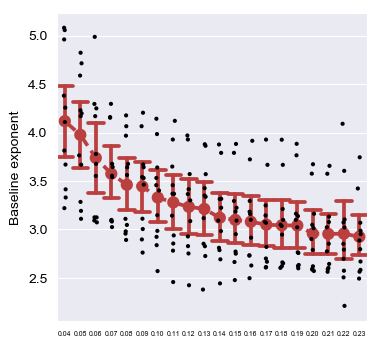

0.04      0.05      0.06      0.07      0.08      0.09      0.10  \
0   3.330189  3.192075  3.073522  3.091692  2.980623  3.004504  2.924068   
1   4.108521  3.284678  3.092541  3.024534  2.892172  2.761703  2.570676   
2   4.961027  4.588278  4.249756  4.159743  3.968024  3.541113  3.531675   
3   4.380755  4.198508  3.779434  3.540361  2.957162  2.897250  2.838223   
4   5.081731  4.824003  4.295500  4.296331  4.177132  4.204933  4.142704   
5   3.669991  3.668656  3.677654  3.677172  3.676324  3.462948  3.401957   
6   3.220217  3.110052  3.124772  3.098543  3.109892  3.111128  3.147007   
7   4.257538  4.169371  4.169371  4.153567  4.065803  4.065486  3.984577   
8   3.414384  4.229230  3.125310  3.082383  3.046880  3.670820  2.985726   
9   5.057620  4.714915  4.987820  3.644640  3.639866  3.531227  3.457590   
10  3.814154  3.764130  3.551936  3.554798  3.562209  3.642786  3.639648   

        0.11      0.12      0.13      0.14      0.15      0.16      0.17  \
0   2.855203  2.828273  2.827171  2.811037  2.771949  2.732998  2.700471   
1   2.457638  2.424426  2.380127  2.443589  2.477949  2.497357  2.607700   
2   3.368196  3.300438  3.426315  2.983073  2.951543  2.915695  2.820187   
3   2.781660  2.752495  2.726219  2.692026  2.664311  2.628392  2.612776   
4   4.121251  3.970423  3.879521  3.876850  3.882975  3.915220  3.927856   
5   3.368806  3.365630  3.350398  3.313744  3.294393  3.294392  3.248105   
6   3.142835  3.086385  3.116340  3.091803  3.091843  3.100483  3.068947   
7   3.928429  3.928631  3.863832  3.790678  3.790883  3.723394  3.667089   
8   2.938705  2.928170  2.852653  2.787009  2.750714  2.731007  2.667225   
9   3.456897  3.415301  3.337540  3.224371  3.224270  3.183716  3.145053   
10  3.649264  3.571557  3.570890  3.316433  3.184979  3.158728  3.078844   

        0.18      0.19      0.20      0.21      0.22      0.23  
0   2.621566  2.622505  2.585966  2.563629  2.505816  2.493371  
1   2.660650  2.757387  2.571564  2.774460  2.851707  2.886415  
2   2.946814  2.764346  2.789538  2.644616  2.696933  2.669430  
3   2.604084  2.599279  2.595195  2.589782  2.211765  2.583309  
4   3.926307  3.884064  3.673284  3.656910  3.605121  3.423019  
5   3.211956  3.163052  3.162494  3.133032  3.103254  3.069613  
6   3.050754  3.138303  3.013070  3.076941  3.072469  2.952572  
7   3.667047  3.765364  3.576154  3.575116  4.090819  3.744958  
8   2.650926  2.633953  2.619980  2.603681  2.574422  2.564285  
9   3.098917  3.099092  3.047764  3.022333  3.020897  2.986908  
10  3.036419  3.022336  2.901009  2.853006  2.791841  2.796969

In [54]:
pltfn.boxplot(avdic, 'Baseline exponent', (4,4), 10, 5, 3, 1)

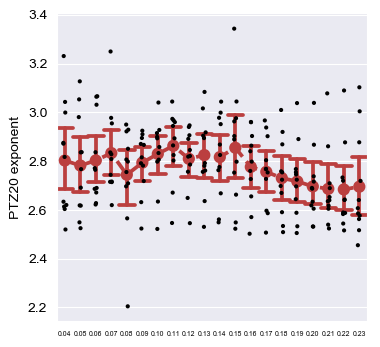

0.04      0.05      0.06      0.07      0.08      0.09      0.10  \
0   3.230633  3.126942  3.065945  2.954705  2.921859  2.894846  2.893423   
1   2.633585  2.691255  2.690007  2.619656  2.204847  2.523651  2.521972   
2   2.613536  2.525051  2.686236  2.808633  2.806511  2.866413  2.899626   
3   3.042612  3.053036  3.063992  3.249315  2.949797  2.870447  2.833011   
4   2.871567  2.836766  2.836382  2.835528  2.850622  2.815461  2.806021   
5   2.519716  2.549063  2.627842  2.715105  2.798079  2.910081  2.927660   
6   2.874738  2.767232  2.764496  2.713992  2.708794  2.718305  3.040092   
7   2.620199  2.617540  2.622151  2.716257  2.696669  2.791183  2.797864   
8   2.603666  2.618572  2.671386  2.743782  2.755217  2.781631  2.857819   
9   2.999078  2.980425  3.031096  2.977259  2.928859  2.924664  2.914891   
10  2.817096  2.835853  2.771071  2.828013  2.565383  2.631806  2.634288   

        0.11      0.12      0.13      0.14      0.15      0.16      0.17  \
0   2.824796  2.820950  2.761393  2.561031  2.522836  2.570544  2.596678   
1   2.546420  2.545710  2.530532  2.549051  2.548615  2.502364  2.506971   
2   2.967202  2.946518  2.917792  2.867900  2.888973  2.840432  2.803804   
3   2.973207  2.845560  2.756107  2.825085  2.662526  2.655385  2.586593   
4   2.802506  2.756566  2.780744  2.775616  2.752892  2.726613  2.727082   
5   2.944145  2.905880  2.904395  2.951578  2.902741  2.960442  2.937716   
6   3.044120  2.785931  3.083608  2.998670  3.342940  2.797998  2.753535   
7   2.959757  2.939923  3.016058  3.043744  3.044288  2.959398  2.966715   
8   2.864306  2.818422  2.791777  2.762915  2.797667  2.759805  2.767009   
9   2.893361  2.891043  2.894380  2.977597  2.975750  2.863409  2.768436   
10  2.670876  2.649041  2.636171  2.668023  2.962748  2.902931  2.902135   

        0.18      0.19      0.20      0.21      0.22      0.23  
0   2.534072  2.532940  2.532136  2.539486  2.544179  2.576816  
1   2.508940  2.505258  2.531519  2.523847  2.515952  2.516779  
2   2.723705  2.723850  2.687038  2.639487  2.640675  2.640441  
3   2.590657  2.588268  2.605060  2.604767  2.587652  2.607115  
4   2.697982  2.643970  2.618400  2.617504  2.583013  2.585524  
5   2.919673  2.890296  2.867167  2.860783  2.876883  2.877195  
6   2.669580  2.696465  2.690145  2.689205  2.732900  3.004113  
7   3.009610  3.037854  3.038660  3.077678  3.089495  3.102562  
8   2.758317  2.767406  2.716168  2.652519  2.642409  2.455306  
9   2.753944  2.754478  2.737640  2.709070  2.719734  2.718877  
10  2.868753  2.745473  2.633422  2.635525  2.589362  2.562498

In [55]:
pltfn.boxplot(pavdic, 'PTZ20 exponent', (4,4), 10, 5, 3, 1)

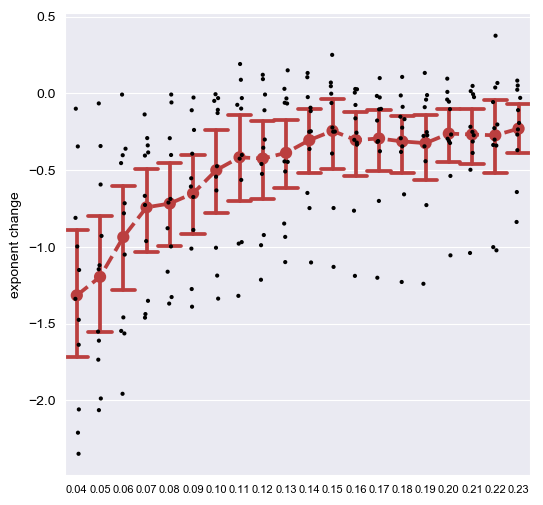

0.04      0.05      0.06      0.07      0.08      0.09      0.10  \
0  -0.099556 -0.065133 -0.007577 -0.136988 -0.058764 -0.109658 -0.030645   
1  -1.474936 -0.593423 -0.402535 -0.404878 -0.687325 -0.238051 -0.048704   
2  -2.347491 -2.063228 -1.563520 -1.351110 -1.161513 -0.674700 -0.632050   
3  -1.338143 -1.145472 -0.715442 -0.291046 -0.007365 -0.026803 -0.005212   
4  -2.210164 -1.987237 -1.459118 -1.460804 -1.326510 -1.389471 -1.336683   
5  -1.150275 -1.119593 -1.049812 -0.962068 -0.878245 -0.552867 -0.474298   
6  -0.345479 -0.342819 -0.360276 -0.384551 -0.401098 -0.392823 -0.106915   
7  -1.637339 -1.551831 -1.547220 -1.437310 -1.369134 -1.274303 -1.186713   
8  -0.810718 -1.610658 -0.453924 -0.338601 -0.291663 -0.889189 -0.127907   
9  -2.058542 -1.734490 -1.956724 -0.667381 -0.711007 -0.606563 -0.542699   
10 -0.997059 -0.928277 -0.780865 -0.726785 -0.996826 -1.010979 -1.005360   

        0.11      0.12      0.13      0.14      0.15      0.16      0.17  \
0  -0.030407 -0.007323 -0.065778 -0.250005 -0.249113 -0.162454 -0.103793   
1   0.088782  0.121284  0.150405  0.105462  0.070666  0.005007 -0.100729   
2  -0.400994 -0.353920 -0.508522 -0.115173 -0.062570 -0.075263 -0.016383   
3   0.191548  0.093065  0.029888  0.133060 -0.001785  0.026994 -0.026183   
4  -1.318745 -1.213857 -1.098777 -1.101234 -1.130082 -1.188607 -1.200773   
5  -0.424661 -0.459750 -0.446004 -0.362167 -0.391653 -0.333950 -0.310389   
6  -0.098715 -0.300454 -0.032732 -0.093133  0.251097 -0.302485 -0.315412   
7  -0.968672 -0.988708 -0.847774 -0.746934 -0.746594 -0.763996 -0.700374   
8  -0.074399 -0.109749 -0.060876 -0.024095  0.046953  0.028798  0.099784   
9  -0.563536 -0.524259 -0.443161 -0.246774 -0.248520 -0.320308 -0.376617   
10 -0.978389 -0.922516 -0.934718 -0.648410 -0.222231 -0.255797 -0.176709   

        0.18      0.19      0.20      0.21      0.22      0.23  
0  -0.087494 -0.089564 -0.053830 -0.024143  0.038363  0.083446  
1  -0.151709 -0.252128 -0.040045 -0.250612 -0.335754 -0.369636  
2  -0.223109 -0.040496 -0.102500 -0.005129 -0.056258 -0.028988  
3  -0.013426 -0.011012  0.009866  0.014985  0.375887  0.023805  
4  -1.228324 -1.240095 -1.054884 -1.039406 -1.022108 -0.837495  
5  -0.292283 -0.272756 -0.295327 -0.272249 -0.226370 -0.192418  
6  -0.381174 -0.441838 -0.322925 -0.387736 -0.339569  0.051541  
7  -0.657437 -0.727510 -0.537494 -0.497438 -1.001325 -0.642395  
8   0.107391  0.133453  0.096188  0.048838  0.067987 -0.108979  
9  -0.344974 -0.344615 -0.310124 -0.313263 -0.301163 -0.268031  
10 -0.167666 -0.276863 -0.267587 -0.217481 -0.202480 -0.234471

In [60]:
pltfn.boxplot(diffdic, 'exponent change', (6,6), 10, 8, 3, 1)

In [64]:
#BRANCH diff
ballist, pallist, difflist = list(range(20)),list(range(20)),list(range(20))
namelist = adfn.name_zero('back', 0.04, 0.23, 0.01)
for i in range(20):
    bnnblist = list(range(11))
    pnnblist = list(range(11))
    diffnnblist = list(range(11))
    for t in range(11):
        bnnblist[t] = blnbranch[i][t]
        pnnblist[t] = ptzbranch[i][t]
        diffnnblist[t] = pnnblist[t] - bnnblist[t]
    ballist[i], pallist[i], difflist[i] = bnnblist, pnnblist, diffnnblist
diffdic, avdic, pavdic = {},{},{}
for i in range(20):
    diffdic[namelist[i]] = difflist[i]
    avdic[namelist[i]] = ballist[i]
    pavdic[namelist[i]] = pallist[i]

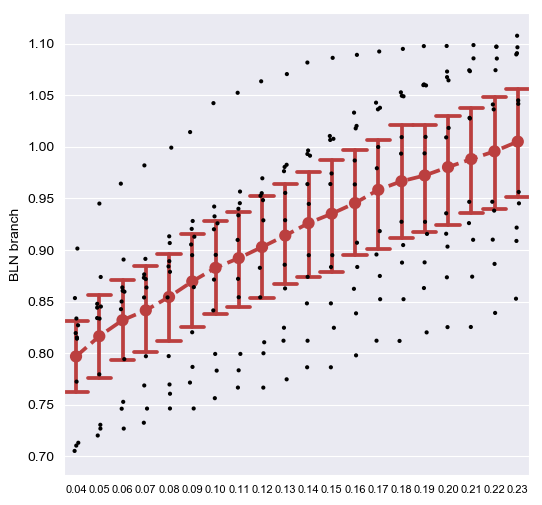

0.04      0.05      0.06      0.07      0.08      0.09      0.10  \
0   0.853334  0.873771  0.890682  0.891338  0.906690  0.920390  0.932520   
1   0.901358  0.944922  0.964215  0.981910  0.999114  1.014209  1.042247   
2   0.819398  0.833975  0.850023  0.871715  0.889100  0.905260  0.920022   
3   0.833552  0.844075  0.859535  0.876287  0.913194  0.928035  0.942037   
4   0.705215  0.720161  0.746123  0.746267  0.760621  0.771456  0.783044   
5   0.772373  0.779448  0.794161  0.796980  0.797096  0.820209  0.841387   
6   0.815149  0.833452  0.842590  0.853945  0.853998  0.863948  0.871261   
7   0.713124  0.726872  0.726872  0.732532  0.746347  0.746347  0.756333   
8   0.813988  0.847762  0.860421  0.873058  0.884025  0.912798  0.925787   
9   0.710374  0.730535  0.752782  0.768651  0.769615  0.786628  0.799210   
10  0.827008  0.845133  0.863663  0.863590  0.878784  0.894942  0.895212   

        0.11      0.12      0.13      0.14      0.15      0.16      0.17  \
0   0.945315  0.954984  0.955248  0.963780  0.974100  0.986667  0.999755   
1   1.052289  1.063406  1.070414  1.081599  1.086139  1.089033  1.092301   
2   0.933572  0.948239  0.976300  0.991312  1.006558  1.020179  1.036253   
3   0.956566  0.969423  0.982509  0.996364  1.010424  1.033049  1.042707   
4   0.783336  0.799863  0.812036  0.812003  0.824555  0.838542  0.852242   
5   0.854152  0.854037  0.862700  0.873898  0.883442  0.883468  0.895572   
6   0.871977  0.882662  0.885644  0.894895  0.894906  0.906975  0.918230   
7   0.766615  0.766575  0.774607  0.786281  0.786281  0.797831  0.812044   
8   0.939892  0.952454  0.980398  0.992964  1.007685  1.017794  1.037739   
9   0.799240  0.810522  0.824596  0.848209  0.848210  0.862305  0.874768   
10  0.909699  0.928702  0.928809  0.944595  0.963842  0.963513  0.979168   

        0.18      0.19      0.20      0.21      0.22      0.23  
0   1.009307  1.009537  1.018225  1.027391  1.036196  1.044920  
1   1.094809  1.097509  1.097626  1.098518  1.096905  1.096359  
2   1.048835  1.060387  1.072884  1.085638  1.096984  1.107557  
3   1.052704  1.059710  1.067456  1.074097  1.074179  1.089458  
4   0.852244  0.863066  0.873466  0.874082  0.886457  0.908711  
5   0.904713  0.915511  0.915685  0.925987  0.938091  0.945147  
6   0.927294  0.927224  0.935505  0.946609  0.946704  0.956183  
7   0.811817  0.820087  0.825194  0.825311  0.838949  0.852738  
8   1.049366  1.059408  1.064359  1.073200  1.085484  1.090652  
9   0.887719  0.887944  0.903227  0.909823  0.909968  0.921630  
10  0.993319  0.993598  1.009047  1.027989  1.040951  1.041583

In [67]:
pltfn.boxplot(avdic, 'BLN branch', (6,6), 10, 8, 3, 1)

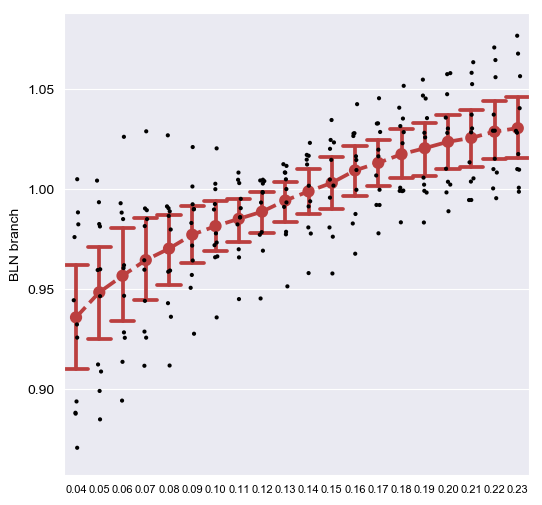

0.04      0.05      0.06      0.07      0.08      0.09      0.10  \
0   0.888338  0.908930  0.928466  0.944205  0.958766  0.971817  0.972012   
1   0.925879  0.946548  0.946739  0.964490  0.979842  0.992432  0.999983   
2   0.944515  0.959605  0.962016  0.959765  0.959349  0.964367  0.966418   
3   0.887901  0.899230  0.913774  0.928868  0.943056  0.957148  0.973330   
4   0.893981  0.912449  0.925766  0.925837  0.936263  0.950734  0.965979   
5   0.988394  0.993472  0.992959  0.990357  0.988915  0.983094  0.977907   
6   0.932439  0.959981  0.960586  0.981555  0.991394  1.001320  1.002686   
7   1.004951  1.004258  1.026123  1.028867  1.026869  1.021020  1.020355   
8   0.976054  0.981362  0.985046  0.985033  0.986643  0.990049  0.992546   
9   0.870853  0.885037  0.894410  0.911802  0.911926  0.927795  0.935944   
10  0.982419  0.982560  0.988282  0.989484  0.990473  0.989924  0.989831   

        0.11      0.12      0.13      0.14      0.15      0.16      0.17  \
0   0.985845  0.998238  1.008348  1.017099  1.024553  1.027931  1.032851   
1   1.004673  1.004703  1.012448  1.016669  1.023319  1.026523  1.028538   
2   0.969961  0.969268  0.977425  0.980875  0.980867  0.987589  0.992077   
3   0.986036  0.998537  1.011601  1.023101  1.034515  1.042426  1.045387   
4   0.965929  0.977212  0.991136  0.991368  1.004764  1.016409  1.016392   
5   0.982381  0.978508  0.978697  0.977835  0.976247  0.982848  0.992107   
6   1.003019  1.004319  1.004916  1.012301  1.014614  1.014560  1.019706   
7   1.008270  1.002786  1.000036  1.001686  1.001779  1.009546  1.006826   
8   0.995153  1.004015  1.008188  1.014728  1.020130  1.027746  1.032743   
9   0.945091  0.945403  0.951449  0.958078  0.957885  0.967745  0.977943   
10  0.990497  0.993313  0.993365  0.993932  0.995758  0.999666  0.999678   

        0.18      0.19      0.20      0.21      0.22      0.23  
0   1.035243  1.035463  1.035716  1.037153  1.037214  1.040415  
1   1.028458  1.028134  1.028085  1.028371  1.029155  1.029094  
2   0.999125  0.999152  1.002270  1.005372  1.009987  1.010011  
3   1.051584  1.054672  1.057405  1.063370  1.064448  1.067668  
4   1.031481  1.046715  1.057918  1.058088  1.070730  1.076595  
5   0.999001  1.005734  1.010176  1.013397  1.015160  1.017529  
6   1.022924  1.025860  1.030271  1.030312  1.029181  1.028184  
7   1.000712  0.998292  0.998360  0.994576  0.995471  0.998705  
8   1.040660  1.045237  1.047399  1.052440  1.055893  1.056395  
9   0.983423  0.983343  0.988958  0.994554  1.000358  1.000709  
10  0.999282  1.002231  1.003676  1.003774  1.008287  1.009695

In [68]:
pltfn.boxplot(pavdic, 'BLN branch', (6,6), 10, 8, 3, 1)

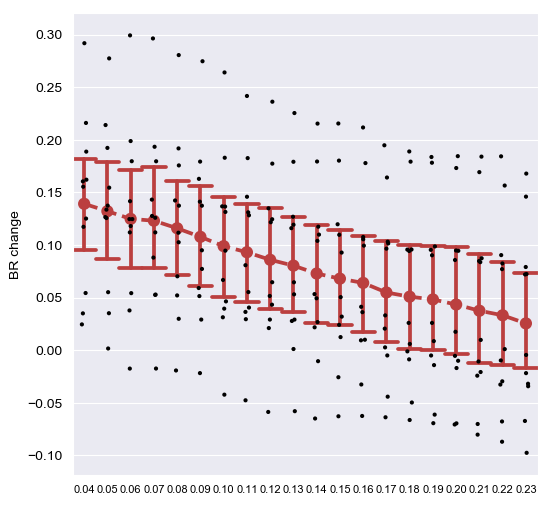

0.04      0.05      0.06      0.07      0.08      0.09      0.10  \
0   0.035005  0.035158  0.037783  0.052867  0.052075  0.051427  0.039492   
1   0.024521  0.001625 -0.017475 -0.017420 -0.019272 -0.021777 -0.042264   
2   0.125116  0.125630  0.111993  0.088050  0.070249  0.059107  0.046396   
3   0.054348  0.055155  0.054239  0.052580  0.029862  0.029113  0.031293   
4   0.188766  0.192288  0.179643  0.179569  0.175642  0.179278  0.182934   
5   0.216021  0.214024  0.198798  0.193377  0.191819  0.162886  0.136520   
6   0.117290  0.126529  0.117996  0.127610  0.137396  0.137371  0.131425   
7   0.291827  0.277386  0.299252  0.296335  0.280522  0.274673  0.264023   
8   0.162067  0.133600  0.124625  0.111976  0.102617  0.077250  0.066760   
9   0.160479  0.154503  0.141628  0.143151  0.142311  0.141167  0.136733   
10  0.155412  0.137427  0.124619  0.125894  0.111690  0.094982  0.094619   

        0.11      0.12      0.13      0.14      0.15      0.16      0.17  \
0   0.040530  0.043254  0.053100  0.053318  0.050453  0.041264  0.033096   
1  -0.047616 -0.058703 -0.057967 -0.064930 -0.062819 -0.062510 -0.063763   
2   0.036389  0.021029  0.001125 -0.010438 -0.025691 -0.032590 -0.044177   
3   0.029469  0.029114  0.029092  0.026737  0.024091  0.009377  0.002681   
4   0.182594  0.177349  0.179100  0.179365  0.180209  0.177867  0.164150   
5   0.128230  0.124471  0.115997  0.103937  0.092805  0.099380  0.096535   
6   0.131042  0.121656  0.119271  0.117407  0.119708  0.107585  0.101477   
7   0.241656  0.236210  0.225429  0.215405  0.215497  0.211715  0.194782   
8   0.055261  0.051560  0.027790  0.021764  0.012445  0.009952 -0.004995   
9   0.145852  0.134881  0.126852  0.109870  0.109675  0.105440  0.103174   
10  0.080798  0.064611  0.064555  0.049337  0.031916  0.036153  0.020510   

        0.18      0.19      0.20      0.21      0.22      0.23  
0   0.025936  0.025926  0.017491  0.009762  0.001018 -0.004505  
1  -0.066351 -0.069375 -0.069542 -0.070147 -0.067750 -0.067265  
2  -0.049710 -0.061235 -0.070614 -0.080266 -0.086997 -0.097546  
3  -0.001120 -0.005037 -0.010051 -0.010727 -0.009731 -0.021791  
4   0.179237  0.183649  0.184452  0.184006  0.184273  0.167883  
5   0.094288  0.090223  0.094491  0.087410  0.077069  0.072381  
6   0.095630  0.098636  0.094765  0.083704  0.082477  0.072001  
7   0.188895  0.178205  0.173165  0.169264  0.156523  0.145966  
8  -0.008707 -0.014171 -0.016960 -0.020760 -0.029591 -0.034257  
9   0.095704  0.095399  0.085731  0.084731  0.090390  0.079079  
10  0.005963  0.008633 -0.005371 -0.024215 -0.032664 -0.031888

In [69]:
pltfn.boxplot(diffdic, 'BR change', (6,6), 10, 8, 3, 1)

In [75]:
#LLR
ballist, pallist = list(range(20)),list(range(20))
namelist = adfn.name_zero('back', 0.04, 0.23, 0.01)
for i in range(20):
    bnnblist = list(range(11))
    pnnblist = list(range(11))
    for t in range(11):
        bnnblist[t] = bexplist[i][t][0]
        pnnblist[t] = pexplist[i][t][0]
    ballist[i], pallist[i] = bnnblist, pnnblist
avdic, pavdic = {}, {}
for i in range(20):
    avdic[namelist[i]] = ballist[i]
    pavdic[namelist[i]] = pallist[i]

In [77]:
#LLR - p
ballist, pallist = list(range(20)),list(range(20))
namelist = adfn.name_zero('back', 0.04, 0.23, 0.01)
for i in range(20):
    bnnblist = list(range(11))
    pnnblist = list(range(11))
    for t in range(11):
        bnnblist[t] = bexplist[i][t][1]
        pnnblist[t] = pexplist[i][t][1]
    ballist[i], pallist[i] = bnnblist, pnnblist
avdic, pavdic = {}, {}
for i in range(20):
    avdic[namelist[i]] = ballist[i]
    pavdic[namelist[i]] = pallist[i]

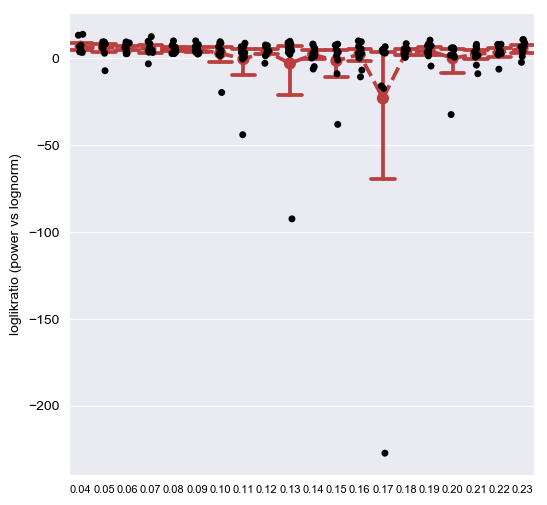

0.04      0.05      0.06       0.07      0.08      0.09       0.10  \
0    7.255803  7.627257  4.062907   4.114595  2.694675  5.137961   2.146142   
1    6.406487  8.284070  5.632824   4.207743  6.050114  3.335837   1.235363   
2    4.091736  8.831541  2.523006  -3.404346  4.376591  5.801081   8.683938   
3    3.540226  5.352584  2.343050   4.914641  7.150495  6.536926   6.467093   
4    3.478333  9.205419  5.887054   5.986008  2.555934  2.211117   2.264543   
5   13.582450  7.358817  8.069686   3.261685  3.276440  4.120489   4.491006   
6    6.713705  7.971521  5.670055  12.218493  4.432002  3.287352 -19.871121   
7   13.037103  9.202754  9.202754   9.550386  9.796323  9.779341   9.311521   
8    5.400782  6.365443  8.614452   8.265490  7.373628  2.794756   3.404245   
9    4.572078  2.700165  6.094302   4.600408  4.758248  7.624254   8.476874   
10   3.125992 -7.357370  3.046103   3.100588  2.522788  2.618386   3.525815   

         0.11      0.12       0.13      0.14       0.15       0.16  \
0    3.150788  3.386552   4.206883  2.520079   3.760354   1.021108   
1    0.731886  2.918405   2.061887  2.035447 -38.224191  -0.173573   
2    6.644067  7.446564   5.962395  1.031902   1.235856   2.535911   
3    5.779670  3.968992   7.992561  3.576742  -9.083151  -7.003526   
4    0.439163  3.412642   5.515956  5.524869   4.847748   9.789637   
5   -0.639199 -3.089990   8.761682 -4.995197        NaN   9.287595   
6    2.726994  1.201868   3.177221 -6.407133   3.123600   2.676040   
7    6.450607  6.461734   6.491432  7.334720   7.344505   6.627046   
8    2.952267  3.173908 -92.538245 -0.088727  -1.211046 -10.887745   
9    8.447316  7.045055   9.564201  7.964734   7.910322   5.217440   
10 -44.157215  4.092886   4.134342  2.789801   3.334685   3.531434   

          0.17      0.18       0.19       0.20      0.21      0.22       0.23  
0     3.220629  2.216340   2.357103 -32.561121  0.482091  2.407803   3.574799  
1   -17.523686  2.519935  10.223520   1.543640  6.797404  7.770919  10.527512  
2     3.280427  2.287433   6.988880   5.644807  2.814368  1.911756   3.370577  
3   -16.091683       NaN   7.072756        NaN -4.134300 -6.463022  10.483195  
4     6.445633  8.196317   3.207515   5.813896  5.301440  2.766816   6.744893  
5          NaN  0.316587  -4.681713        NaN  3.477696  5.997423   3.911677  
6     2.765935  0.522508   1.130222   0.415220  1.471129       NaN  -2.513566  
7     4.983014  4.997882   5.263323   5.392894  5.479857  3.935738   6.385976  
8  -227.267599  4.101895   8.138837   4.441544 -9.116670  3.252270   0.829871  
9     4.411376  5.230714   4.359607   5.683078  7.796540  7.829337   8.667661  
10    3.362108       NaN   3.027389   1.845129  3.329347  2.232667   6.319501

In [72]:
pltfn.boxplot(avdic, 'loglikratio (power vs lognorm)', (6,6), 10, 8, 5, 1)

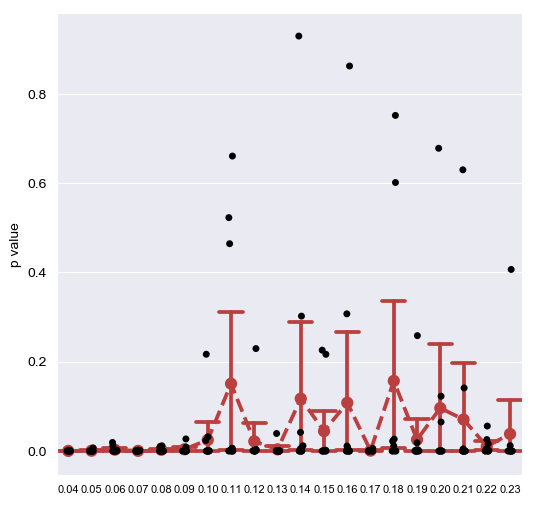

0.04          0.05          0.06          0.07          0.08  \
0   3.992846e-13  2.398019e-14  4.846529e-05  3.878593e-05  7.045738e-03   
1   1.489108e-10  1.190352e-16  1.772826e-08  2.579344e-05  1.447433e-09   
2   4.281557e-05  1.032433e-18  1.163564e-02  6.632278e-04  1.205499e-05   
3   3.997844e-04  8.670712e-08  1.912683e-02  8.894540e-07  8.646582e-13   
4   5.045425e-04  3.403402e-20  3.931413e-09  2.150543e-09  1.059031e-02   
5   5.089479e-42  1.855473e-13  7.047913e-16  1.107521e-03  1.051247e-03   
6   1.897443e-11  1.567338e-15  1.427518e-08  2.476326e-34  9.336194e-06   
7   7.526238e-39  3.488926e-20  3.488926e-20  1.292145e-21  1.167586e-22   
8   6.635107e-08  1.947265e-10  7.027669e-18  1.391227e-16  1.660459e-13   
9   4.829112e-06  6.930512e-03  1.099162e-09  4.216638e-06  1.952805e-06   
10  1.772063e-03  1.875693e-13  2.318280e-03  1.931371e-03  1.164286e-02   

            0.09          0.10          0.11          0.12          0.13  \
0   2.777359e-07  3.186166e-02  1.628306e-03  7.077690e-04  2.589174e-05   
1   8.504294e-04  2.166953e-01  4.642383e-01  3.518274e-03  3.921849e-02   
2   6.588868e-09  3.822976e-18  3.051445e-11  9.580239e-14  2.485678e-09   
3   6.279596e-11  9.990613e-11  7.484733e-09  7.217728e-05  1.321644e-15   
4   2.702776e-02  2.354075e-02  6.605434e-01  6.433630e-04  3.468898e-08   
5   3.780692e-05  7.088761e-06  5.226936e-01  2.001633e-03  1.923579e-18   
6   1.011344e-03  7.236807e-88  6.391419e-03  2.294145e-01  1.486936e-03   
7   1.381074e-22  1.260143e-20  1.114031e-10  1.035098e-10  8.502420e-11   
8   5.193884e-03  6.634717e-04  3.154502e-03  1.504011e-03  0.000000e+00   
9   2.454491e-14  2.313247e-17  2.980768e-17  1.853881e-12  1.130711e-21   
10  8.834678e-03  4.221812e-04  0.000000e+00  4.260375e-05  3.559727e-05   

            0.14          0.15          0.16          0.17          0.18  \
0   1.173283e-02  1.696734e-04  3.072035e-01  1.279096e-03  2.666824e-02   
1   4.180588e-02  0.000000e+00  8.622010e-01  9.450040e-69  1.173765e-02   
2   3.021180e-01  2.165121e-01  1.121552e-02  1.036502e-03  2.217055e-02   
3   3.479033e-04  1.054757e-19  2.495989e-12  2.917945e-58           NaN   
4   3.297324e-08  1.248712e-06  1.247430e-22  1.151191e-10  2.478650e-16   
5   5.877578e-07           NaN  1.578141e-20           NaN  7.515572e-01   
6   1.482814e-10  1.786529e-03  7.449778e-03  5.675986e-03  6.013164e-01   
7   2.221851e-13  2.065224e-13  3.424702e-11  6.260135e-07  5.796349e-07   
8   9.292988e-01  2.258776e-01  1.318648e-27  0.000000e+00  4.097807e-05   
9   1.655794e-15  2.567246e-15  1.814133e-07  1.027159e-05  1.688563e-07   
10  5.274041e-03  8.539623e-04  4.133133e-04  7.735000e-04           NaN   

            0.19           0.20          0.21          0.22          0.23  
0   1.841811e-02  1.457308e-232  6.297412e-01  1.604884e-02  3.504973e-04  
1   1.555859e-24   1.226757e-01  1.065213e-11  7.791888e-15  6.451712e-26  
2   2.770900e-12   1.653665e-08  4.887329e-03  5.590745e-02  7.501081e-04  
3   1.518865e-12            NaN  3.560378e-05  1.026325e-10  1.031974e-25  
4   1.338871e-03   6.103524e-09  1.148929e-07  5.660676e-03  1.531402e-11  
5   2.844869e-06            NaN  5.057427e-04  2.004733e-09  9.165737e-05  
6   2.583827e-01   6.779805e-01  1.412563e-01           NaN  1.195175e-02  
7   1.414750e-07   6.933186e-08  4.256703e-08  8.294126e-05  1.703075e-10  
8   3.990941e-16   8.931549e-06  7.746802e-20  1.144874e-03  4.066115e-01  
9   1.302960e-05   1.322918e-08  6.362775e-15  4.904493e-15  4.410860e-18  
10  2.466767e-03   6.501880e-02  8.705000e-04  2.557091e-02  2.624094e-10

In [74]:
pltfn.boxplot(avdic, 'p value', (6,6), 10, 8, 5, 1)

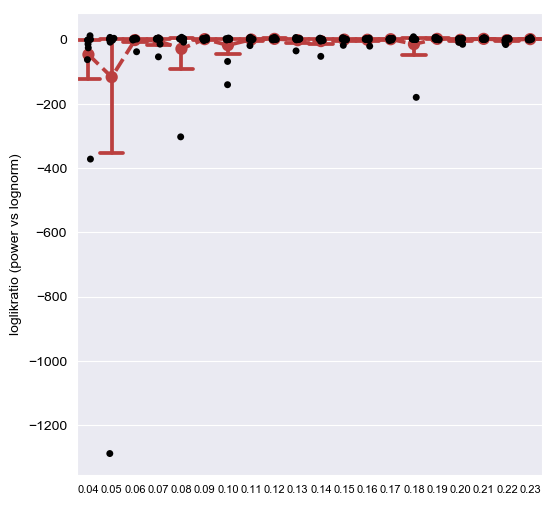

0.04         0.05       0.06       0.07        0.08      0.09  \
0          NaN     0.140580   2.578001   1.557560    3.556512  1.779321   
1    12.326359     7.166971   5.184086 -13.770910    4.966613 -2.800682   
2    -1.471762     4.348347   2.139170   4.132596    3.013429  0.796021   
3   -13.842191     1.036855   2.013718   5.582309    0.723758  1.243744   
4    -2.042744 -1288.163735   3.214512   1.774971   -7.632107  1.557803   
5   -25.325935     0.987141   3.164793   3.986751    2.818466  0.517438   
6     0.865170     1.511939 -37.457031   1.950272    2.281672  0.907752   
7    -0.606089     0.631711   2.498270   4.747384    7.542266  2.921801   
8   -62.083291     1.602102  -1.012070   2.018238 -302.397834  2.278379   
9  -371.565987    -1.418504   3.984430 -53.330034         NaN  3.562579   
10    1.022779    -7.670357   1.607612   3.578361    1.181799  6.420945   

          0.10       0.11      0.12       0.13       0.14       0.15  \
0     1.518492   0.633307  4.412380   6.751933  -1.440969  -0.593421   
1   -67.682255   1.662655 -0.625110  -0.431359   0.989074   0.877993   
2     1.600770   1.887537  6.403331   1.657579   0.562781   1.418993   
3     3.240190   5.001926  3.277970   2.260046   1.461190   0.770769   
4     2.373358 -18.415529  2.114120   0.488581  -2.760306   3.194141   
5  -140.052857   1.559297  0.967008   3.204735  -4.478864 -17.566647   
6     5.116490   4.600627  0.521123   1.472747   2.271199   2.333670   
7     2.675697   7.379327  6.714772        NaN   4.857674   4.349145   
8    -0.833121  -2.080690  1.815552 -34.827732 -51.843905   1.072341   
9     0.820512   1.223126  0.649424   0.859532   1.030730   1.068421   
10    2.788505   1.337241  1.735132   3.547140   2.180279   6.133342   

         0.16      0.17        0.18      0.19       0.20      0.21       0.22  \
0    1.794345  1.996560    0.599684  2.471559   2.898261  0.472388  -0.005980   
1    1.284278  0.721864    1.091355  1.561696  -8.084170  2.778047 -15.099170   
2    1.107401 -0.727849    3.727647  3.929039   1.812315  4.811777   1.530170   
3    0.934322 -0.099665    1.569716  1.281543   0.797760  0.444751 -10.691198   
4    2.167320  2.139481    1.983061  0.320739  -1.202702  0.777875  -1.207578   
5  -20.085451  1.117749    1.191742 -0.479623 -14.311065  1.575878  -2.063531   
6    1.862372  4.086226    1.284477  2.307471   3.656566  3.657549   4.402377   
7    2.454496 -2.648041 -179.411874  1.444608   2.030235  1.143351   1.256037   
8    3.047155  4.205930    9.120161  7.204445   3.059432  6.387223   3.782798   
9   -0.368093  2.028733    2.355823  2.376095   2.632564  3.365446   1.432657   
10   4.640468  3.806183    4.338918  6.646424   2.514641  2.953959   2.925825   

        0.23  
0   2.958414  
1  -0.738844  
2   1.604032  
3   0.971789  
4   0.496213  
5   2.670618  
6   6.796148  
7   1.668608  
8  -0.457724  
9   1.430590  
10  2.099921

In [76]:
pltfn.boxplot(pavdic, 'loglikratio (power vs lognorm)', (6,6), 10, 8, 5, 1)

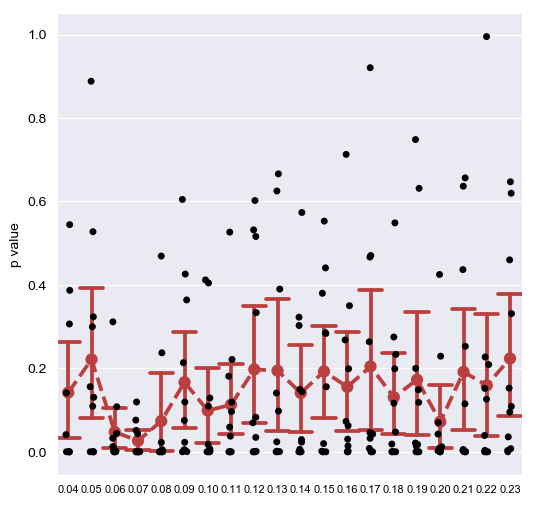

0.04          0.05           0.06          0.07          0.08  \
0             NaN  8.882018e-01   9.937375e-03  1.193376e-01  3.758120e-04   
1    6.533260e-35  7.667533e-13   2.170762e-07  3.813806e-43  6.813253e-07   
2    1.410850e-01  1.371673e-05   3.242191e-02  3.586887e-05  2.583138e-03   
3    1.418171e-43  2.998034e-01   4.403912e-02  2.373459e-08  4.692141e-01   
4    4.107781e-02  0.000000e+00   1.306664e-03  7.590260e-02  2.309481e-14   
5   1.655040e-141  3.235733e-01   1.551932e-03  6.698438e-05  4.825366e-03   
6    3.869457e-01  1.305494e-01  4.615173e-307  5.114376e-02  2.250869e-02   
7    5.444555e-01  5.275756e-01   1.248011e-02  2.060642e-06  4.618729e-14   
8    0.000000e+00  1.091330e-01   3.115044e-01  4.356643e-02  0.000000e+00   
9    0.000000e+00  1.560435e-01   6.764240e-05  0.000000e+00           NaN   
10   3.064124e-01  1.715184e-14   1.079203e-01  3.457553e-04  2.372855e-01   

            0.09          0.10          0.11          0.12           0.13  \
0   7.518720e-02  1.288905e-01  5.265332e-01  1.022404e-05   1.458885e-11   
1   5.099480e-03  0.000000e+00  9.638152e-02  5.318990e-01   6.662071e-01   
2   4.260200e-01  1.094279e-01  5.908818e-02  1.520236e-10   9.740254e-02   
3   2.135938e-01  1.194500e-03  5.676032e-07  1.045565e-03   2.381837e-02   
4   1.192798e-01  1.762719e-02  9.862055e-76  3.450502e-02   6.251385e-01   
5   6.048501e-01  0.000000e+00  1.189262e-01  3.335400e-01   1.351869e-03   
6   3.640091e-01  3.112738e-07  4.212215e-06  6.022811e-01   1.408192e-01   
7   3.480139e-03  7.457394e-03  1.590916e-13  1.883602e-11            NaN   
8   2.270399e-02  4.047766e-01  3.746231e-02  6.943908e-02  9.254799e-266   
9   3.672293e-04  4.119241e-01  2.212822e-01  5.160641e-01   3.900473e-01   
10  1.354312e-10  5.295196e-03  1.811441e-01  8.271738e-02   3.894381e-04   

        0.14          0.15          0.16      0.17          0.18  \
0   0.149593  5.528993e-01  7.275814e-02  0.045873  5.487169e-01   
1   0.322627  3.799477e-01  1.990448e-01  0.470378  2.751168e-01   
2   0.573584  1.559009e-01  2.681208e-01  0.466706  1.932759e-04   
3   0.143963  4.408438e-01  3.501381e-01  0.920610  1.164812e-01   
4   0.005775  1.402474e-03  3.021047e-02  0.032397  4.736062e-02   
5   0.000008  4.436268e-69  9.892075e-90  0.263674  2.333626e-01   
6   0.023135  1.961303e-02  6.255067e-02  0.000044  1.989750e-01   
7   0.000001  1.366694e-05  1.410823e-02  0.008096  0.000000e+00   
8   0.000000  2.835668e-01  2.310183e-03  0.000026  7.501283e-20   
9   0.302667  2.853307e-01  7.128037e-01  0.042486  1.848171e-02   
10  0.029237  8.605170e-10  3.476206e-06  0.000141  1.431856e-05   

            0.19          0.20          0.21          0.22          0.23  
0   1.345254e-02  3.752378e-03  6.366497e-01  9.952290e-01  3.092268e-03  
1   1.183597e-01  6.258879e-16  5.468676e-03  1.639857e-51  4.600019e-01  
2   8.528610e-05  6.993747e-02  1.495939e-06  1.259747e-01  1.087070e-01  
3   2.000031e-01  4.250099e-01  6.564997e-01  1.119154e-26  3.311554e-01  
4   7.484085e-01  2.290916e-01  4.366429e-01  2.272096e-01  6.197439e-01  
5   6.314957e-01  1.866319e-46  1.150538e-01  3.906221e-02  7.571185e-03  
6   2.102855e-02  2.556168e-04  2.546386e-04  1.070711e-05  1.074532e-11  
7   1.485680e-01  4.233269e-02  2.528930e-01  2.091026e-01  9.519508e-02  
8   5.828055e-13  2.217575e-03  1.689255e-10  1.550752e-04  6.471511e-01  
9   1.749694e-02  8.474310e-03  7.642016e-04  1.519558e-01  1.525479e-01  
10  3.002984e-11  1.191536e-02  3.137253e-03  3.435439e-03  3.573578e-02

In [78]:
pltfn.boxplot(pavdic, 'p value', (6,6), 10, 8, 5, 1)

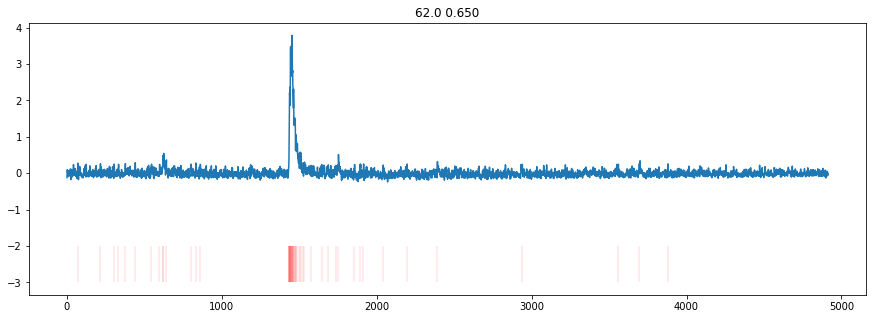

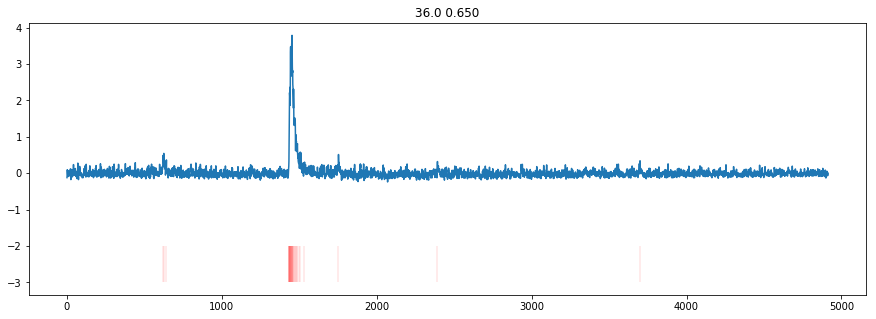

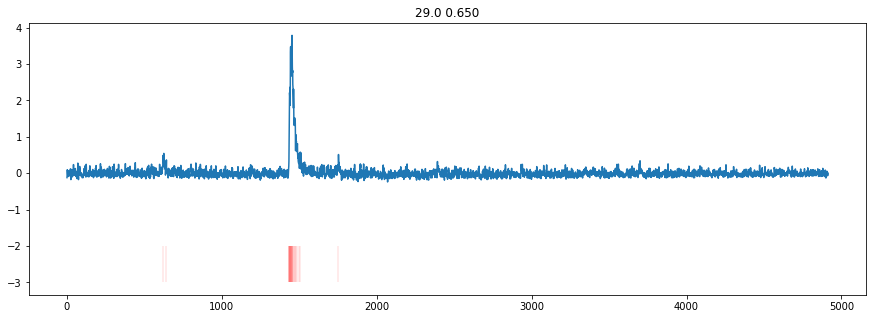

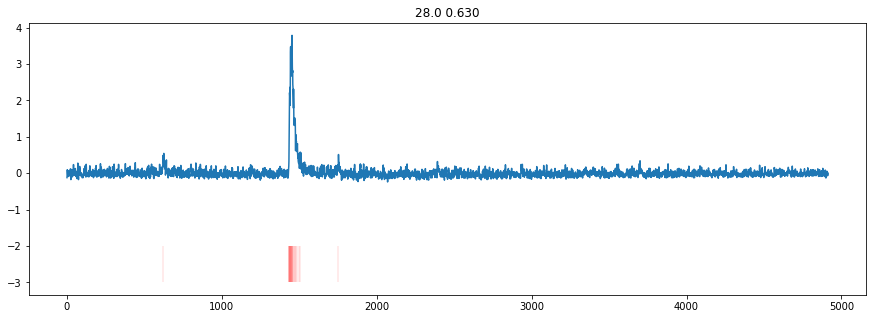

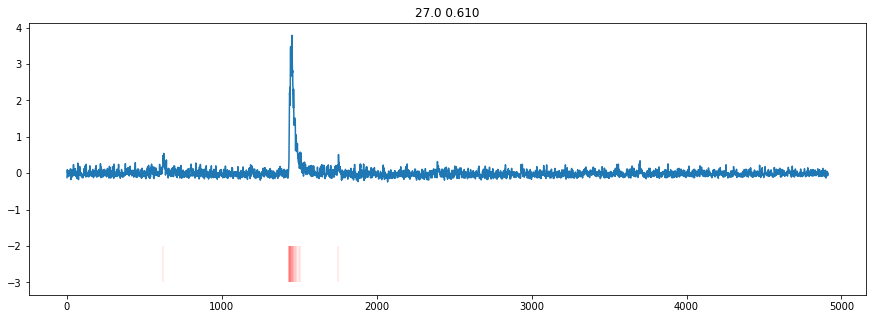

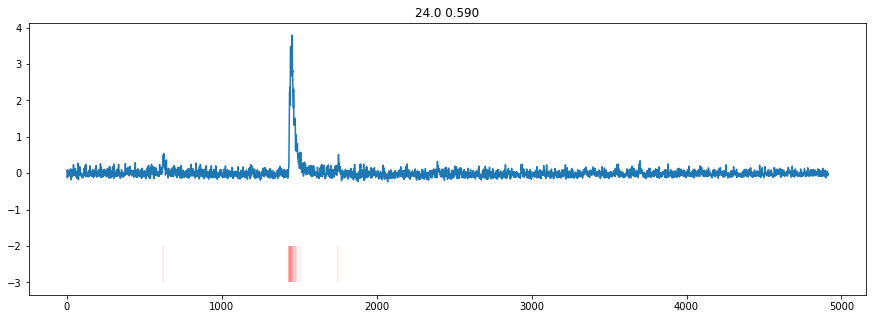

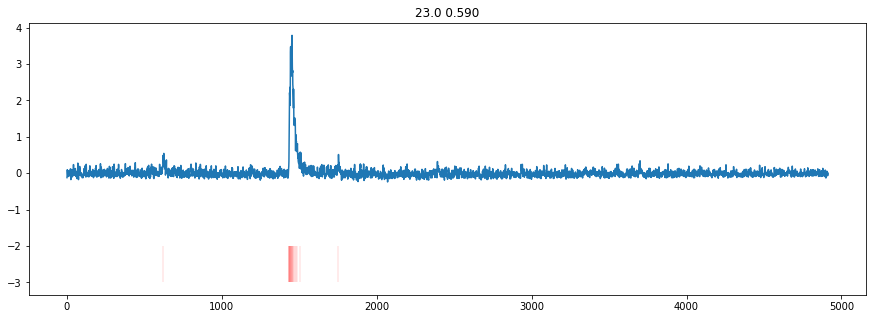

In [6]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
c = 3

os.chdir(F10t + 'Project/' + experiment)
binlist = sorted(glob.glob('*BLN*0.690binarised.npy'))
callist = sorted(glob.glob('*BLN*0.690modelcal.npy'))
dlist = sorted(glob.glob('*BLN*deltaff.npy'))
f, axarr = plt.subplots(figsize = (15,5))
plt.plot(np.load(dlist[0])[c])
#plt.plot(np.load(callist[0])[c])
for x in np.where(np.load(binlist[0])[c] == 1)[0]: plt.vlines(x=x,  alpha = 0.1, ymin = -3, ymax = -2, color = 'red')
plt.title(str(np.sum(np.load(binlist[0])[c]))+ str(' 0.650'))

os.chdir(F10t + 'Project/' + experiment)
binlist = sorted(glob.glob('*BLN*0.670binarised.npy'))
callist = sorted(glob.glob('*BLN*0.670modelcal.npy'))
dlist = sorted(glob.glob('*BLN*deltaff.npy'))
f, axarr = plt.subplots(figsize = (15,5))
plt.plot(np.load(dlist[0])[c])
#plt.plot(np.load(callist[0])[c])
for x in np.where(np.load(binlist[0])[c] == 1)[0]: plt.vlines(x=x,  alpha = 0.1, ymin = -3, ymax = -2, color = 'red')
plt.title(str(np.sum(np.load(binlist[0])[c]))+ str(' 0.650'))

os.chdir(F10t + 'Project/' + experiment)
binlist = sorted(glob.glob('*BLN*0.650binarised.npy'))
callist = sorted(glob.glob('*BLN*0.650modelcal.npy'))
dlist = sorted(glob.glob('*BLN*deltaff.npy'))
f, axarr = plt.subplots(figsize = (15,5))
plt.plot(np.load(dlist[0])[c])
#plt.plot(np.load(callist[0])[c])
for x in np.where(np.load(binlist[0])[c] == 1)[0]: plt.vlines(x=x,  alpha = 0.1, ymin = -3, ymax = -2, color = 'red')
plt.title(str(np.sum(np.load(binlist[0])[c]))+ str(' 0.650'))

os.chdir(F10t + 'Project/' + experiment)
binlist = sorted(glob.glob('*BLN*0.630binarised.npy'))
callist = sorted(glob.glob('*BLN*0.630modelcal.npy'))
dlist = sorted(glob.glob('*BLN*deltaff.npy'))
f, axarr = plt.subplots(figsize = (15,5))
plt.plot(np.load(dlist[0])[c])
#plt.plot(np.load(callist[0])[c])
for x in np.where(np.load(binlist[0])[c] == 1)[0]: plt.vlines(x=x,  alpha = 0.1, ymin = -3, ymax = -2, color = 'red')
plt.title(str(np.sum(np.load(binlist[0])[c]))+ str(' 0.630'))

os.chdir(F10t + 'Project/' + experiment)
binlist = sorted(glob.glob('*BLN*0.610binarised.npy'))
callist = sorted(glob.glob('*BLN*0.610modelcal.npy'))
dlist = sorted(glob.glob('*BLN*deltaff.npy'))
f, axarr = plt.subplots(figsize = (15,5))
plt.plot(np.load(dlist[0])[c])
#plt.plot(np.load(callist[0])[c])
for x in np.where(np.load(binlist[0])[c] == 1)[0]: plt.vlines(x=x,  alpha = 0.1, ymin = -3, ymax = -2, color = 'red')
plt.title(str(np.sum(np.load(binlist[0])[c]))+ str(' 0.610'))

os.chdir(F10t + 'Project/' + experiment)
binlist = sorted(glob.glob('*BLN*0.590binarised.npy'))
callist = sorted(glob.glob('*BLN*0.590modelcal.npy'))
dlist = sorted(glob.glob('*BLN*deltaff.npy'))
f, axarr = plt.subplots(figsize = (15,5))
plt.plot(np.load(dlist[0])[c])
#plt.plot(np.load(callist[0])[c])
for x in np.where(np.load(binlist[0])[c] == 1)[0]: plt.vlines(x=x,  alpha = 0.1, ymin = -3, ymax = -2, color = 'red')
plt.title(str(np.sum(np.load(binlist[0])[c]))+ str(' 0.590'))
plt.show()

os.chdir(F10t + 'Project/' + experiment)
binlist = sorted(glob.glob('*BLN*0.570binarised.npy'))
callist = sorted(glob.glob('*BLN*0.570modelcal.npy'))
dlist = sorted(glob.glob('*BLN*deltaff.npy'))
f, axarr = plt.subplots(figsize = (15,5))
plt.plot(np.load(dlist[0])[c])
#plt.plot(np.load(callist[0])[c])
for x in np.where(np.load(binlist[0])[c] == 1)[0]: plt.vlines(x=x,  alpha = 0.1, ymin = -3, ymax = -2, color = 'red')
plt.title(str(np.sum(np.load(binlist[0])[c]))+ str(' 0.590'))
plt.show()